# Imports, constants and functions

In [1]:
import os
import re
import nrrd
import numbers
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import pingouin as pg
import radiomics as pr
import SimpleITK as sitk
import matplotlib.pyplot as plt
from radiomics import featureextractor
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.ndimage import binary_dilation, binary_erosion
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# Configura pandas para mostrar todo el DataFrame
pd.set_option('display.max_rows', None)      # Todas las filas
pd.set_option('display.max_columns', None)   # Todas las columnas
pd.set_option('display.width', None)         # Todo el ancho posible
pd.set_option('display.max_colwidth', None)  # Ancho completo del contenido de la columna

In [3]:
# Constantes
INPUT_PATH = '/Users/veramegias/Documents/Universidad/Cuarto/TFG/Segmentaciones'
IMAGES_PATH = 'images'
OUTPUT_PATH = 'outputs'
DATA_PATH = 'data'
REEXECUTE = False
MAX_NUM = 43

columns_file_text = f'{OUTPUT_PATH}/columnas_df_features.txt'

In [4]:
def preprocess_features(df, label_column, threshold_corr=0.95, threshold_var=0.01):
    """
    Preprocesa un DataFrame eliminando variables constantes, colineales y normalizando los datos.

    Pasos:
        1. Separa las variables independientes (X) y la variable objetivo (y).
        2. Elimina variables con baja varianza (prácticamente constantes).
        3. Elimina variables con alta correlación para reducir colinealidad.
        4. Normaliza las características con StandardScaler.

    Args:
        df (pd.DataFrame): DataFrame con las características radiómicas y la columna de la variable objetivo.
        label_column (str): Nombre de la columna que contiene la variable objetivo.
        threshold_corr (float): Umbral de correlación para eliminar variables (default 0.95).
        threshold_var (float): Umbral de varianza mínima para eliminar variables constantes (default 0.01).
    
    Returns:
        pd.DataFrame: DataFrame con las características preprocesadas, filtradas y normalizadas.
        pd.Series: Variable objetivo (y).
        list: Lista de variables eliminadas.
    """
    n_variables = len(df.columns)
    # 1. Separar la variable objetivo (y) de las características (X)
    X = df.drop(columns=[label_column])  # Todas las columnas excepto la de la etiqueta
    y = df[label_column]                 # Columna de la variable objetivo
    
    # 2. Eliminar variables con baja varianza
    var_selector = VarianceThreshold(threshold=threshold_var)
    X_var_filtered = pd.DataFrame(var_selector.fit_transform(X), columns=X.columns[var_selector.get_support()])
    removed_low_var = list(set(X.columns) - set(X_var_filtered.columns))
    
    print(f"Se eliminaron {len(removed_low_var)} variables con baja varianza.")

    # 3. Eliminar variables altamente correlacionadas
    corr_matrix = X_var_filtered.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold_corr)]
    
    X_filtered = X_var_filtered.drop(columns=to_drop)
    
    print(f"Se eliminaron {len(to_drop)} variables altamente correlacionadas.")

    # 4. Normalizar las características con StandardScaler y devolverlo como DataFrame
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_filtered), columns=X_filtered.columns, index=X.index)
    
    print(f'Se han eliminado {len(removed_low_var + to_drop)} de {n_variables} variables')

    return X_scaled, y, removed_low_var + to_drop

In [5]:
def same_sizes(image1, image2):
    """
    Comprueba que la imagen 1 y la imagen 1 tienen las mismas dimensiones.
    
    Args:
        image1 (SimpleITK.Image): Imagen 1.
        image2 (SimpleITK.Image): Imagen 2.
    
    Returns:
        boolean: Si el tamaño coincide
    
    """
    return image1.GetSize() == image2.GetSize()

In [6]:
def simulate_resegmentation(mask, method, iterations):
    """
    Simula una segunda segmentación modificando la máscara original.
    
    Parámetros:
        mask (sitk.Image): Máscara original.
        method (str): 'dilation' o 'erosion'. Se usa para simular una resegmentación.
        iterations (int): Número de iteraciones de la operación morfológica.
    
    Retorna:
        sitk.Image: Máscara modificada.
    
    """
    mask_arr = sitk.GetArrayFromImage(mask)
    
    if method == 'dilation':
        mask_arr_mod = binary_dilation(mask_arr, structure=np.ones((3,3,3)), iterations=iterations)
    elif method == 'erosion':
        mask_arr_mod = binary_erosion(mask_arr, structure=np.ones((3,3,3)), iterations=iterations)
    else:
        raise ValueError("El método debe ser 'dilation' o 'erosion'")
    
    mask_mod = sitk.GetImageFromArray(mask_arr_mod.astype(np.uint8))
    mask_mod.CopyInformation(mask)
    return mask_mod

In [7]:
def simulate_interpolation(image, new_spacing, method_interpol):
    """
    Re-muestrea la imagen a un espaciamiento ligeramente modificado.
    
    Parámetros:
        image (sitk.Image): Imagen original.
        new_spacing (tuple): Nuevo espaciamiento (por ejemplo, (sx, sy, sz)).
    
    Retorna:
        sitk.Image: Imagen re-muestreada.
    """
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    new_size = [int(round(osz * ospc / nspc)) for osz, ospc, nspc in zip(original_size, original_spacing, new_spacing)]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(new_size)
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(image.GetOrigin())
    if method_interpol == "linear":
        resample.SetInterpolator(sitk.sitkLinear)
        new_image = resample.Execute(image)
    elif method_interpol == "B-Spline":
        resample.SetInterpolator(sitk.sitkBSpline)
        new_image = resample.Execute(image)
    else:
        print("[ERROR]  No valid interpolation method. Nothing applied.")
    
    return new_image

In [8]:
def simulate_interpolation_mask(mask, new_spacing):
    """
    Re-muestrea la máscara (usando interpolación de vecino más cercano) a un espaciamiento modificado.
    
    Parámetros:
        mask (sitk.Image): Máscara original.
        new_spacing (tuple): Nuevo espaciamiento.
    
    Retorna:
        sitk.Image: Máscara re-muestreada.
    
    """
    original_spacing = mask.GetSpacing()
    original_size = mask.GetSize()
    new_size = [int(round(osz * ospc / nspc)) for osz, ospc, nspc in zip(original_size, original_spacing, new_spacing)]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(new_size)
    resample.SetOutputDirection(mask.GetDirection())
    resample.SetOutputOrigin(mask.GetOrigin())
    resample.SetInterpolator(sitk.sitkNearestNeighbor)
    new_mask = resample.Execute(mask)
    return new_mask

In [9]:
def get_features(image, mask):
    if same_sizes(image, mask):
        extractor = featureextractor.RadiomicsFeatureExtractor()
    else:
        print(f'[ERROR] Sizes are not the same.')
    features = extractor.execute(image, mask)
    
    return features

In [10]:
def extract_features(image_file_path, mask_file_path, process_type):
    """
    Extrae características radiómicas de una imagen y su máscara utilizando PyRadiomics.
    Args:
        image_file_path (str): Ruta al archivo NRRD que contiene la imagen a analizar.
        mask_file_path (str): Ruta al archivo NRRD que contiene la máscara asociada a la imagen.
    Returns:
        features (dict): Características radiómicas extraídas.
    Extra:
        Comprueba que el tamaño de las imagenes sea compatible.
    """
    # Load paths and images
    image_data, _ = nrrd.read(image_file_path)
    image = sitk.GetImageFromArray(image_data)
    mask_data, _ = nrrd.read(mask_file_path)
    mask = sitk.GetImageFromArray(mask_data)

    if process_type == "resegmentation":
        mask = simulate_resegmentation(mask, method='dilation', iterations=1)
    elif process_type == "interpolation":
        original_spacing = image.GetSpacing()
        new_spacing = tuple([s + 0.1 for s in original_spacing])
        image = simulate_interpolation(image, new_spacing, 'linear')
        mask  = simulate_interpolation_mask(mask, new_spacing)
    elif process_type == "original":
        pass
    else:
        print("[ERROR]  No valid process. Nothing applied.")

    return get_features(image, mask)

In [11]:
def join_original_columns(df_original, df_interes):
    if len(df_original) != len(df_interes):
        raise ValueError("Los DataFrames tienen tamaños diferentes; no se pueden unir correctamente.")
    
    df_final = pd.concat([df_original.reset_index(drop=True), df_interes.reset_index(drop=True)], axis=1)

    return df_final

In [12]:
def compute_icc(df, feature_col, subject_col='subject', method_col='method'):
    """
    Calcula el ICC para una característica dada utilizando los modelos ICC2 e ICC3.
    
    Parámetros:
        df (pd.DataFrame): DataFrame con las mediciones.
        feature_col (str): Nombre de la columna que contiene la característica a evaluar.
        subject_col (str): Columna que identifica al sujeto.
        method_col (str): Columna que identifica el método o la medición.
    
    Retorna:
        dict: Diccionario con los valores de ICC2 e ICC3.
    """
    
    icc_df = pg.intraclass_corr(data=df, targets=feature_col, raters=method_col, ratings=subject_col)
    icc2 = icc_df.loc[icc_df['Type'] == 'ICC2', 'ICC'].values[0]
    icc3 = icc_df.loc[icc_df['Type'] == 'ICC3', 'ICC'].values[0]
    return {'ICC2': icc2, 'ICC3': icc3}

In [13]:
def convert_columns_to_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    Dado un DataFrame, intenta convertir cada columna completa a tipo numérico.
    - Si un valor está dentro de un contenedor unitario (list, tuple, np.ndarray, pd.Series con un solo elemento),
      extrae ese elemento.
    - Si el valor resultante es un número, lo deja tal cual.
    - En otro caso, intenta hacer float(valor).
    - Si cualquier celda de la columna falla, imprime un mensaje y BORRA la columna entera.
    Devuelve un nuevo DataFrame con solo las columnas convertidas correctamente.
    """
    def _extraer_escalar(x):
        if isinstance(x, (list, tuple, np.ndarray, pd.Series)) and len(x) == 1:
            return x[0]
        return x

    def _convertir_valor(x):
        x0 = _extraer_escalar(x)
        if isinstance(x0, numbers.Number):
            return x0
        try:
            return float(x0)
        except Exception:
            raise ValueError(f"No se pudo convertir el valor {x0!r} a número")

    df2 = df.copy()
    cols_a_eliminar = []
    for col in df2.columns:
        try:
            df2[col] = df2[col].apply(_convertir_valor)
        except Exception as e:
            print(f"Fallo en columna '{col}': {e}. Se eliminará la columna.")
            cols_a_eliminar.append(col)

    if cols_a_eliminar:
        df2.drop(columns=cols_a_eliminar, inplace=True)

    return df2

In [14]:
def plot_correlation_matrix(df: pd.DataFrame):
    """
    Mapa de calor de la matriz de correlación, sólo sobre columnas numéricas y no constantes.
    """
    num = df.select_dtypes(include=[np.number])
    num = num.loc[:, num.nunique() > 1]
    if num.shape[1] < 2:
        print("No hay suficientes variables numéricas variables para dibujar la matriz.")
        return
    corr = num.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', mask=mask, square=True)
    plt.title("Matriz de Correlación")
    plt.savefig(f'{IMAGES_PATH}/correlation_matrix.png')
    plt.show()
    plt.close()

In [15]:
def plot_variable_distribution(df: pd.DataFrame):
    nums = df.select_dtypes(include=[np.number]).columns
    for col in nums:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Distribución de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.show()
        plt.close()

In [16]:
def plot_lasso_path(X, y):
    """
    Genera un gráfico del camino de Lasso.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)
    y = y.values.ravel()
    print("Número de condición de X:", np.linalg.cond(X))
    alphas, coefs, _ = lasso_path(X_train_scaled, y, max_iter=10000, tol=1e-3)
    print("Condición de X (escalado):", np.linalg.cond(X_train_scaled))
    plt.figure(figsize=(10, 6))
    for coef in coefs:
        plt.plot(-np.log10(alphas), coef)
    
    plt.xlabel("-Log10(Alpha)")
    plt.ylabel("Coeficientes")
    plt.title("Lasso Path")
    plt.grid(True)
    plt.savefig(f'{IMAGES_PATH}/lasso_path.png')
    plt.show()


In [17]:
def plot_feature_importance(X, y, feature_names):
    """
    Importancia por RandomForest.
    """
    model = RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5)
    model.fit(X, y)
    importance = model.feature_importances_

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importance)
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.title("Importancia de las Características")
    plt.savefig(f'{IMAGES_PATH}/feature_importance_RF.png')
    plt.show()


In [18]:
def filter_columns_by_file(df, file_path):
    """
    Filtra las columnas del dataframe según un archivo con nombres de columnas
    seguidos de "OK" o "NO". Las columnas con "NO" se eliminan.
    """
    columns_to_keep = []

    with open(file_path, "r") as f:
        for line in f:
            column_info = line.strip().split()
            if len(column_info) == 2:  # Asegurarse de que hay un nombre y un estado
                column_name, status = column_info
                if status == "OK":
                    columns_to_keep.append(column_name)

    df_clean = df.copy()
    return df_clean[columns_to_keep]

In [19]:
def compute_icc(df, feature_col, subject_col='subject', method_col='method'):
    """
    Calcula el ICC para una característica dada utilizando ICC2 e ICC3.
    """
    icc_df = pg.intraclass_corr(
        data=df,
        targets=subject_col,
        raters=method_col,
        ratings=feature_col
    )
    icc2 = icc_df.loc[icc_df['Type'] == 'ICC2', 'ICC'].values[0]
    icc3 = icc_df.loc[icc_df['Type'] == 'ICC3', 'ICC'].values[0]
    return {'ICC2': icc2, 'ICC3': icc3}

In [20]:
def analyze_icc(df_original, df_reseg, df_interp):
    """
    Calcula el ICC por pares entre:
      - original vs. resegmentación
      - original vs. interpolación
    """
    orig   = df_original.copy();   orig['method'] = 'original'
    reseg  = df_reseg.copy();      reseg['method']  = 'reseg'
    interp = df_interp.copy();     interp['method'] = 'interp'

    features = [c for c in orig.columns if c not in ['subject', 'method']]

    results = {}
    for feat in features:
        # --- Original vs Resegmentación ---
        pair_reseg = pd.concat([
            orig[['subject', 'method', feat]],
            reseg[['subject', 'method', feat]]
        ], ignore_index=True)
        icc_vals_reseg = compute_icc(pair_reseg, feat, subject_col='subject', method_col='method')
        
        # --- Original vs Interpolación ---
        pair_interp = pd.concat([
            orig[['subject', 'method', feat]],
            interp[['subject', 'method', feat]]
        ], ignore_index=True)
        icc_vals_interp = compute_icc(pair_interp, feat, subject_col='subject', method_col='method')

        # Recoger en resultados
        results[feat] = {
            'ICC2_resegmentation': icc_vals_reseg['ICC2'],
            'ICC3_resegmentation': icc_vals_reseg['ICC3'],
            'ICC2_interpolation':  icc_vals_interp['ICC2'],
            'ICC3_interpolation':  icc_vals_interp['ICC3'],
        }

    return pd.DataFrame.from_dict(results, orient='index')

In [21]:
def filter_features_by_icc(
    df_original: pd.DataFrame,
    df_icc: pd.DataFrame,
    icc2_thresh_reseg: float = 0.75,
    icc3_thresh_reseg: float = 0.75,
    icc2_thresh_interp: float = 0.75,
    icc3_thresh_interp: float = 0.75
):
    """
    Filtra las columnas de df_original en dos nuevas tablas, 
    eliminando las features cuyo ICC está por debajo de los thresholds,
    por separado para resegmentación e interpolación.

    Parámetros:
        df_original: DataFrame original con todas las features (más columnas
                     de identificación como 'subject', etc.).
        df_icc:      DataFrame con índice = nombre de feature, y columnas
                     'ICC2_reseg', 'ICC3_reseg', 'ICC2_interp', 'ICC3_interp'.
        icc2_thresh_reseg:  umbral mínimo de ICC2 para reseg.
        icc3_thresh_reseg:  umbral mínimo de ICC3 para reseg.
        icc2_thresh_interp: umbral mínimo de ICC2 para interp.
        icc3_thresh_interp: umbral mínimo de ICC3 para interp.

    Retorna:
        df_reseg_filtered:   copia de df_original con sólo las features
                             que cumplen ICC2>=icc2_thresh_reseg AND 
                             ICC3>=icc3_thresh_reseg.
        df_interp_filtered:  copia de df_original con sólo las features
                             que cumplen ICC2>=icc2_thresh_interp AND 
                             ICC3>=icc3_thresh_interp.
    """
    # 1) Comprobaciones básicas
    required_cols = {'ICC2_resegmentation','ICC3_resegmentation','ICC2_interpolation','ICC3_interpolation'}
    missing = required_cols - set(df_icc.columns)
    if missing:
        raise ValueError(f"df_icc no contiene columnas: {missing}")

    # 2) Crear máscaras para cada par
    mask_reseg = (
        (df_icc['ICC2_resegmentation']  >= icc2_thresh_reseg) &
        (df_icc['ICC3_resegmentation']  >= icc3_thresh_reseg)
    )
    mask_interp = (
        (df_icc['ICC2_interpolation'] >= icc2_thresh_interp) &
        (df_icc['ICC3_interpolation'] >= icc3_thresh_interp)
    )

    feats_reseg  = df_icc.index[mask_reseg].tolist()
    feats_interp = df_icc.index[mask_interp].tolist()

    # 3) Columnas del original que no son features
    non_feat_cols = [c for c in df_original.columns if c not in df_icc.index]

    # 4) Construcción de los DataFrames filtrados
    df_reseg_filtered  = df_original[ non_feat_cols + feats_reseg ].copy()
    df_interp_filtered = df_original[ non_feat_cols + feats_interp ].copy()

    return df_reseg_filtered, df_interp_filtered

# Load data

In [22]:
# Para cambiar los nombres de los ficheros series, ejecutar en terminal en la carpeta de inputs:
# for file in series*.nrrd; do mv "$file" "${file/series/serie}"; done

In [23]:
if REEXECUTE:
    df_features = pd.DataFrame()

    for num in range(1,MAX_NUM):
        for extension in ['oc', 'ccr']:
            if num == 36 or num == 42 and extension == 'oc':  # Excluir el fichero 36oc y 42oc
                continue
            print(f'Executing {num} for {extension}')
            image_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, 'serie'+str(num)+extension+'.nrrd')
            mask_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, extension+str(num)+'.nrrd')        
            if not os.path.exists(image_path):
                print(f'ERROR: No such file for {image_path}')
            if not os.path.exists(mask_path):
                print(f'ERROR: No such file for {mask_path}')
            features_image = extract_features(image_path, mask_path, "original")
            features_image['cancer'] = 'ccr' in mask_path
            features_image['method'] = "original"
            df_features = pd.concat([df_features, pd.DataFrame([features_image])], ignore_index=True)
    df_features.to_csv('df_features.csv', index=False)
else:
    df_features = pd.read_csv('df_features.csv')

In [24]:
if REEXECUTE:
    df_features_reseg = pd.DataFrame()
    df_features_interp = pd.DataFrame()

    for num in range(1,MAX_NUM):
        for extension in ['oc', 'ccr']:
            if num == 36 or num == 42 and extension == 'oc':  # Excluir el fichero 36oc y 42oc
                continue
            print(f'Executing {num} for {extension}')
            image_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, 'serie'+str(num)+extension+'.nrrd')
            mask_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, extension+str(num)+'.nrrd')

            if not os.path.exists(image_path):
                print(f'ERROR: No such file for {image_path}')
            if not os.path.exists(mask_path):
                print(f'ERROR: No such file for {mask_path}')
            
            features_reseg = extract_features(image_path, mask_path, "resegmentation")
            features_interp = extract_features(image_path, mask_path, "interpolation")
            features_reseg['cancer'] = 'ccr' in mask_path
            features_interp['cancer'] = 'ccr' in mask_path
            features_reseg['subject'] = str(num)
            features_interp['subject'] = str(num)
            features_reseg['method'] = "resegmentation"
            features_interp['method'] = "interpolation"
            df_features_reseg = pd.concat([df_features_reseg, pd.DataFrame([features_reseg])], ignore_index=True)
            df_features_interp = pd.concat([df_features_interp, pd.DataFrame([features_interp])], ignore_index=True)
        
    df_features_reseg.to_csv('df_features_reseg.csv', index=False)
    df_features_interp.to_csv('df_features_interp.csv', index=False)

else:
    df_features_reseg = pd.read_csv('df_features_reseg.csv')
    df_features_interp = pd.read_csv('df_features_interp.csv')

# Clean dataframe

In [25]:
if False:
    with open(f'{columns_file_text}', "w") as f:
        for column in df_features.columns:
            f.write(column + " OK \n")

In [26]:
def funcion_prueba(df_init):
    # Creacion de la columna subject con el digito de cancer
    df = df_init.copy()
    df['aux'] = (df['cancer'] != False).astype(int)
    df['subject_aux'] = df['subject'].astype(str) + df['aux'].astype(str)
    df['subject'] = df['subject_aux'].astype(int)
    df = df.drop('aux', axis=1)
    df = df.drop('cancer', axis=1)
    df = df.drop('subject_aux', axis=1)

    return df

In [27]:
columns_to_keep = ['method']

df_features = funcion_prueba(df_features)

saved_columns = df_features[columns_to_keep].copy()
df_clean = filter_columns_by_file(df_features, columns_file_text)
df_clean = convert_columns_to_numeric(df_clean)
df_clean.drop(columns=columns_to_keep, errors='ignore')
df_clean = pd.concat([saved_columns, df_clean], axis=1)

df_features_reseg = funcion_prueba(df_features_reseg)

saved_columns_reseg = df_features_reseg[columns_to_keep].copy()
df_reseg_clean = filter_columns_by_file(df_features_reseg, columns_file_text)
df_reseg_clean = convert_columns_to_numeric(df_reseg_clean)
df_reseg_clean.drop(columns=columns_to_keep, errors='ignore')
df_reseg_clean = pd.concat([saved_columns_reseg, df_reseg_clean], axis=1)

df_features_interp = funcion_prueba(df_features_interp)

saved_columns_reseg = df_features_interp[columns_to_keep].copy()
df_interp_clean = filter_columns_by_file(df_features_interp, columns_file_text)
df_interp_clean = convert_columns_to_numeric(df_interp_clean)
df_interp_clean.drop(columns=columns_to_keep, errors='ignore')
df_interp_clean = pd.concat([saved_columns_reseg, df_interp_clean], axis=1)

df_clean.to_csv('df_clean.csv', index=False)
df_reseg_clean.to_csv('df_reseg_clean.csv', index=False)
df_interp_clean.to_csv('df_interp_clean.csv', index=False)

Fallo en columna 'diagnostics_Image-original_Hash': No se pudo convertir el valor '8d7665c7a69d5330cb6330fd4c3f96d74645bec8' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Dimensionality': No se pudo convertir el valor '3D' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Spacing': No se pudo convertir el valor '(1.0, 1.0, 1.0)' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Size': No se pudo convertir el valor '(107, 512, 512)' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Hash': No se pudo convertir el valor 'f25e0799ebb7f98db98942f3b4633f507c4bd94c' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Spacing': No se pudo convertir el valor '(1.0, 1.0, 1.0)' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Size': No se pudo convertir el valor '(107, 512, 512)' a número. Se eliminará la columna.
Fallo

# ICC process

In [28]:
results_icc = analyze_icc(df_clean, df_reseg_clean, df_interp_clean)
print("Resultados del ICC para cada característica:")

/Users/veramegias/anaconda3/lib/python3.11/site-packages/pingouin/parametric.py:1008: RuntimeWarning: divide by zero encountered in scalar divide
  fval = msbetween / mserror
/Users/veramegias/anaconda3/lib/python3.11/site-packages/pingouin/reliability.py:320: RuntimeWarning: divide by zero encountered in scalar divide
  f1k = msb / msw
/Users/veramegias/anaconda3/lib/python3.11/site-packages/pingouin/reliability.py:325: RuntimeWarning: divide by zero encountered in scalar divide
  f2k = f3k = msb / mse
/Users/veramegias/anaconda3/lib/python3.11/site-packages/pingouin/reliability.py:354: RuntimeWarning: invalid value encountered in scalar divide
  l1 = (f1l - 1) / (f1l + (k - 1))
/Users/veramegias/anaconda3/lib/python3.11/site-packages/pingouin/reliability.py:355: RuntimeWarning: invalid value encountered in scalar divide
  u1 = (f1u - 1) / (f1u + (k - 1))
/Users/veramegias/anaconda3/lib/python3.11/site-packages/pingouin/reliability.py:358: RuntimeWarning: invalid value encountered in 

Resultados del ICC para cada característica:


In [29]:
results_icc

ICC2_resegmentation  \
diagnostics_Image-original_Mean                                1.000000   
diagnostics_Image-original_Minimum                             1.000000   
diagnostics_Image-original_Maximum                             1.000000   
diagnostics_Mask-original_VoxelNum                             0.989528   
diagnostics_Mask-original_VolumeNum                            1.000000   
original_shape_Elongation                                      0.988927   
original_shape_Flatness                                        0.982584   
original_shape_LeastAxisLength                                 0.976376   
original_shape_MajorAxisLength                                 0.992575   
original_shape_Maximum2DDiameterColumn                         0.993871   
original_shape_Maximum2DDiameterRow                            0.994998   
original_shape_Maximum2DDiameterSlice                          0.995976   
original_shape_Maximum3DDiameter                               0.995373   
original_shape_MeshVolume                                      0.989525   
original_shape_MinorAxisLength                                 0.988645   
original_shape_Sphericity                                      0.922375   
original_shape_SurfaceArea                                     0.994560   
original_shape_SurfaceVolumeRatio                              0.830452   
original_shape_VoxelVolume                                     0.989528   
original_firstorder_10Percentile                               0.374305   
original_firstorder_90Percentile                               0.980687   
original_firstorder_Energy                                     0.997226   
original_firstorder_Entropy                                    0.484327   
original_firstorder_InterquartileRange                         0.524636   
original_firstorder_Kurtosis                                  -0.000344   
original_firstorder_Maximum                                    0.301223   
original_firstorder_MeanAbsoluteDeviation                      0.354293   
original_firstorder_Mean                                       0.923625   
original_firstorder_Median                                     0.988499   
original_firstorder_Minimum                                    0.237796   
original_firstorder_Range                                      0.296119   
original_firstorder_RobustMeanAbsoluteDeviation                0.434999   
original_firstorder_RootMeanSquared                            0.975443   
original_firstorder_Skewness                                   0.361106   
original_firstorder_TotalEnergy                                0.997226   
original_firstorder_Uniformity                                 0.607558   
original_firstorder_Variance                                   0.242159   
original_glcm_Autocorrelation                                  0.239477   
original_glcm_ClusterProminence                                0.117534   
original_glcm_ClusterShade                                     0.182917   
original_glcm_ClusterTendency                                  0.299791   
original_glcm_Contrast                                         0.509818   
original_glcm_Correlation                                      0.544031   
original_glcm_DifferenceAverage                                0.689576   
original_glcm_DifferenceEntropy                                0.621279   
original_glcm_DifferenceVariance                               0.406128   
original_glcm_Id                                               0.831732   
original_glcm_Idm                                              0.821318   
original_glcm_Idmn                                             0.769352   
original_glcm_Idn                                              0.730604   
original_glcm_Imc1                                             0.754668   
original_glcm_Imc2                                             0.563185   
original_glcm_InverseVariance                                  0.824929   
or

In [30]:
results_icc.to_csv('results_icc.csv', index=False)

In [31]:
ICC2_RESEG = 0.75
ICC3_RESEG = 0.75
ICC2_INTERP = 0.75
ICC3_INTERP = 0.75

df_filt_reseg, df_filt_interp = filter_features_by_icc(df_clean, results_icc, ICC2_RESEG, ICC3_RESEG, ICC2_INTERP, ICC3_INTERP)

## See data for ML Algorithms

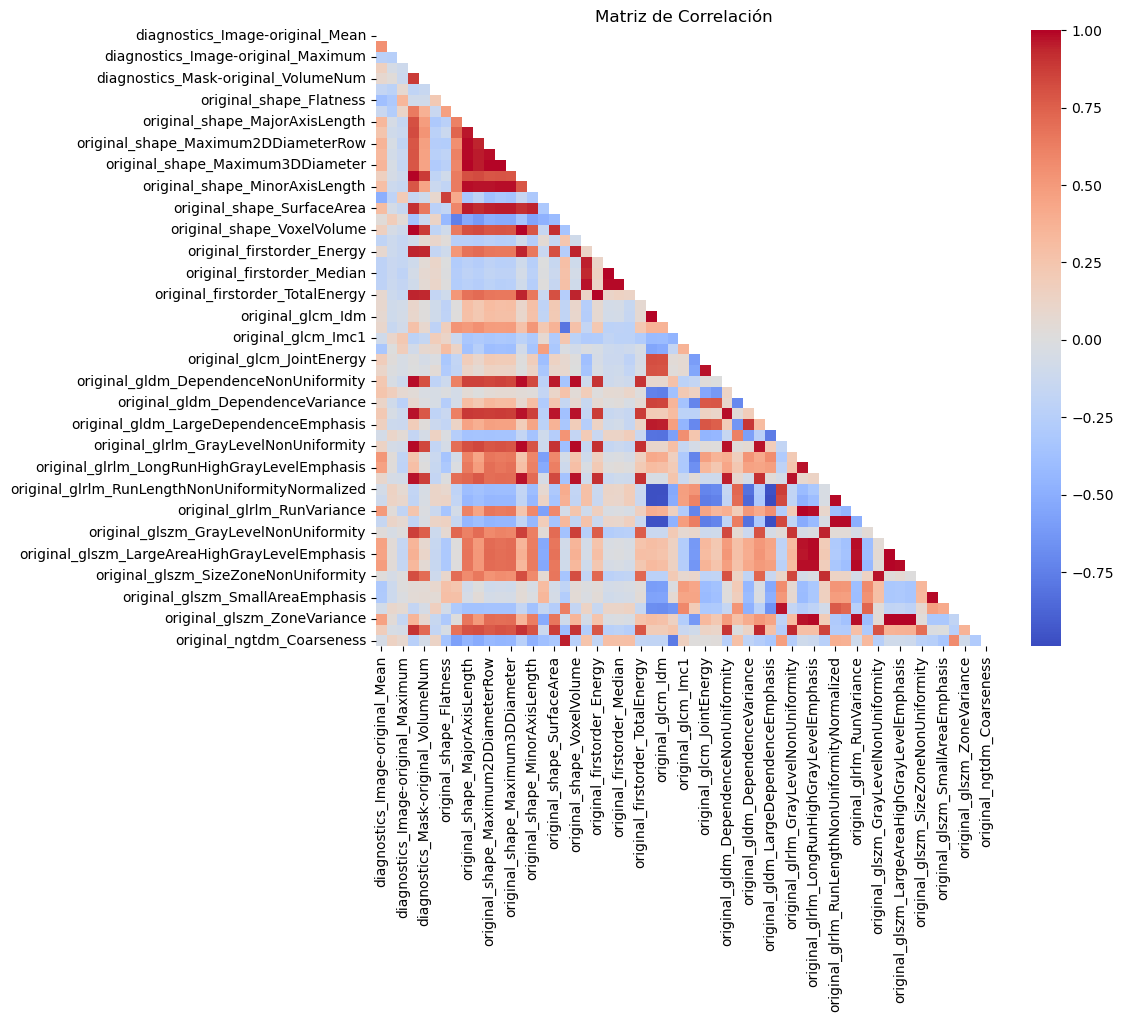

In [32]:
# CUIDADO: No se pintan todas las variables
plot_correlation_matrix(df_filt_reseg.drop(columns=['subject']))

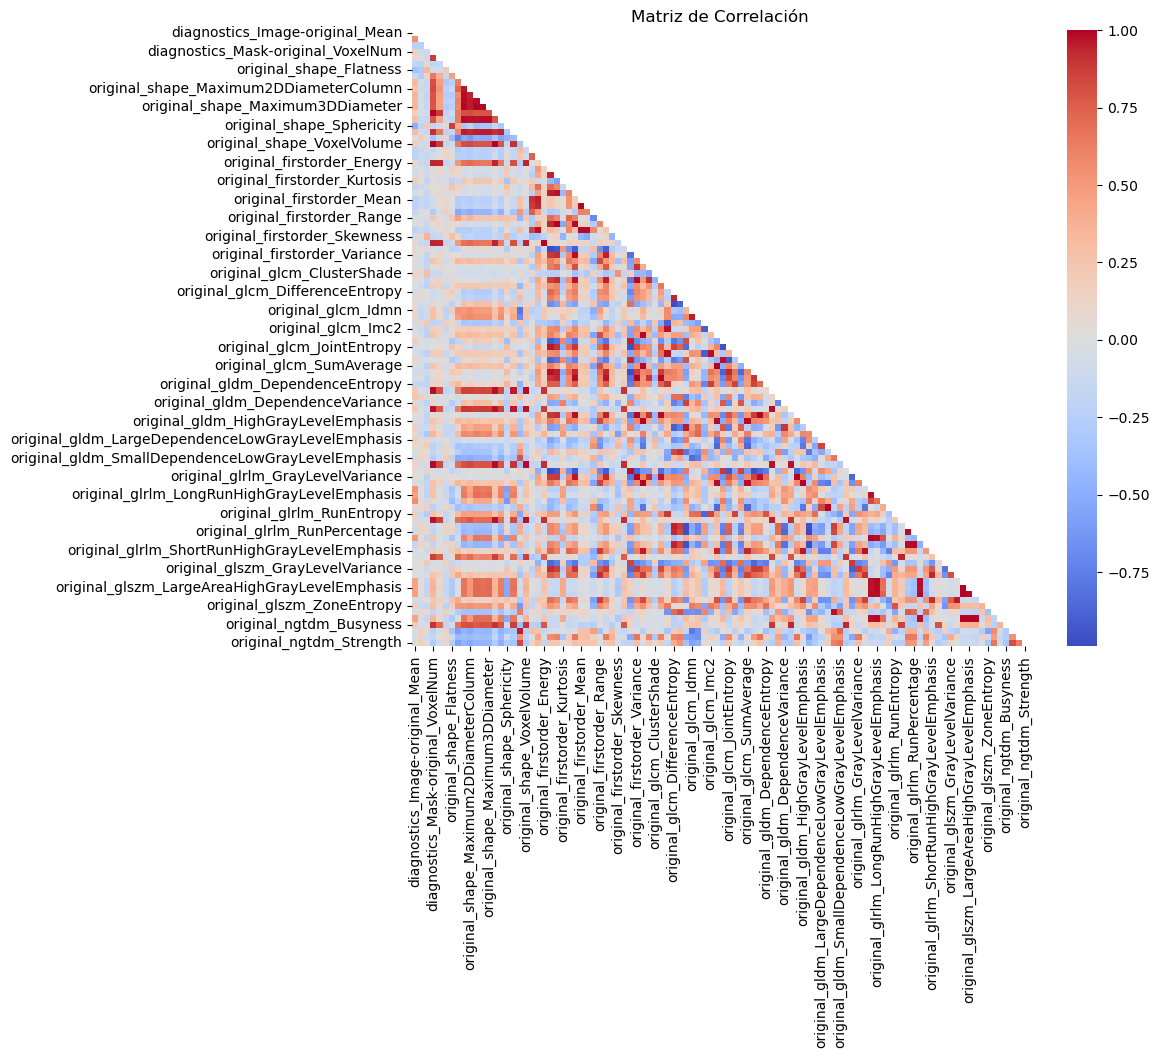

In [33]:
# CUIDADO: No se pintan todas las variables
plot_correlation_matrix(df_filt_interp.drop(columns=['subject']))

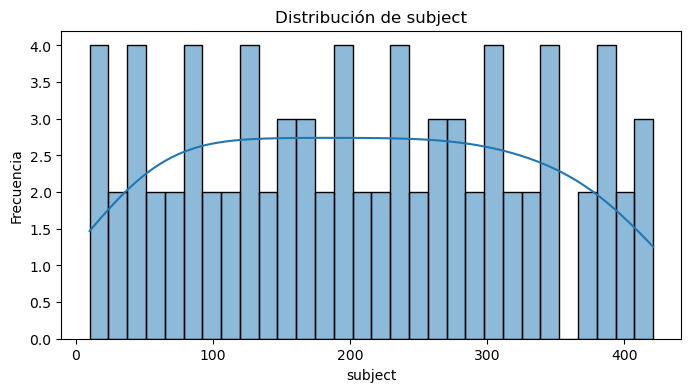

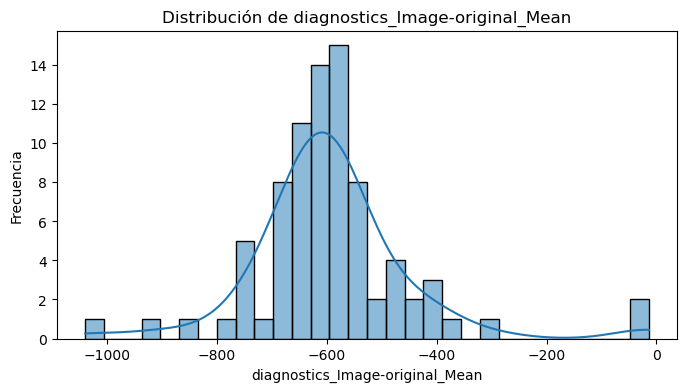

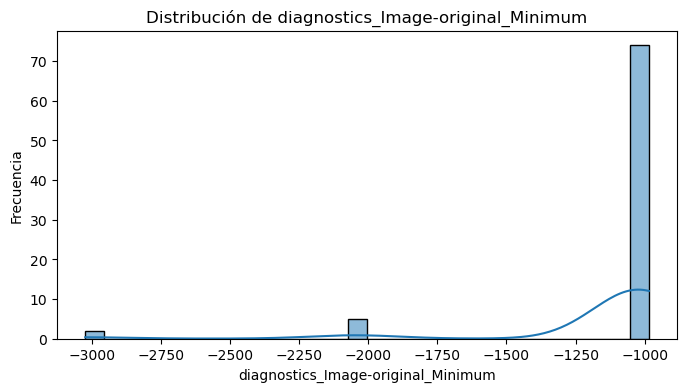

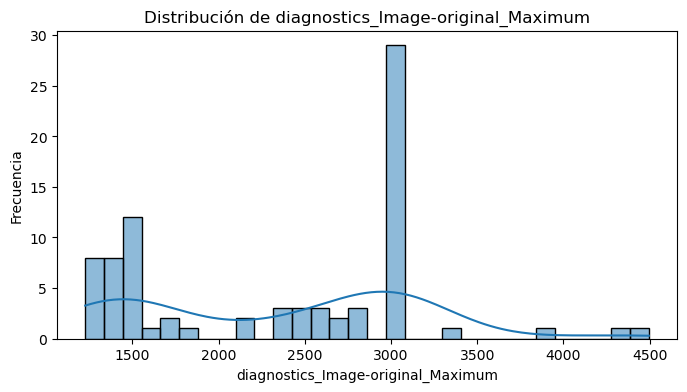

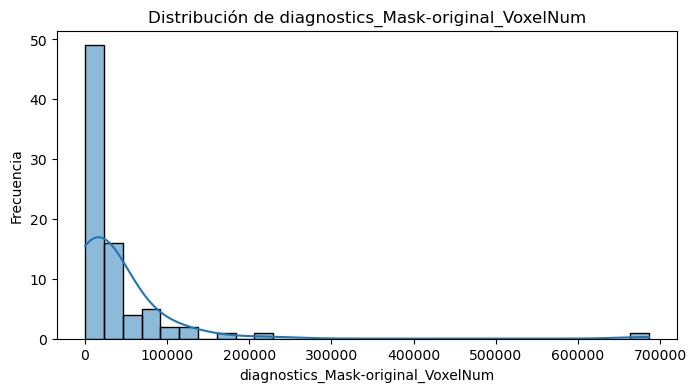

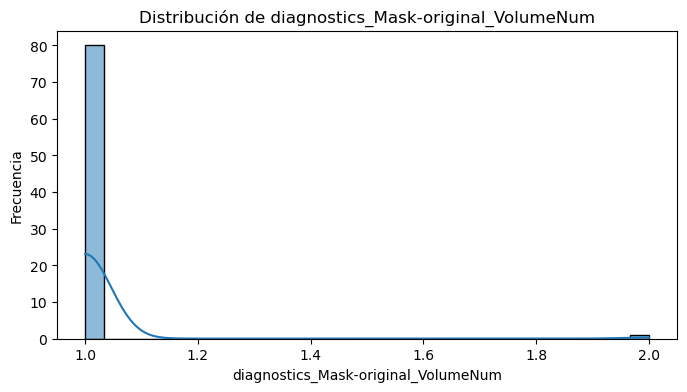

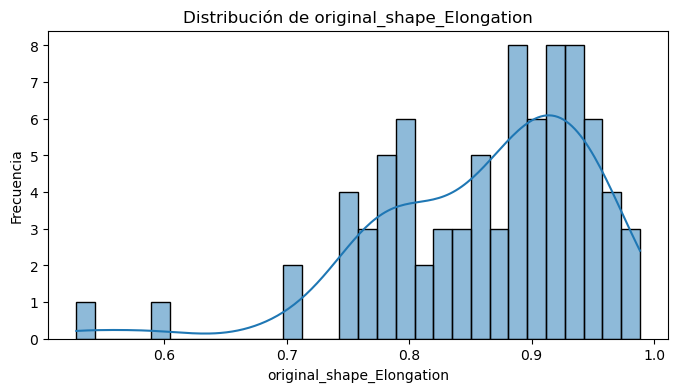

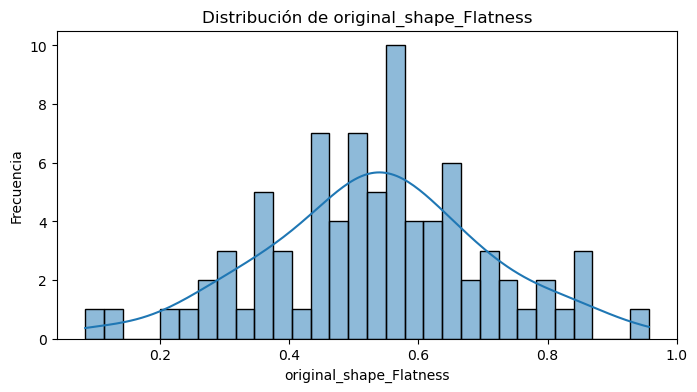

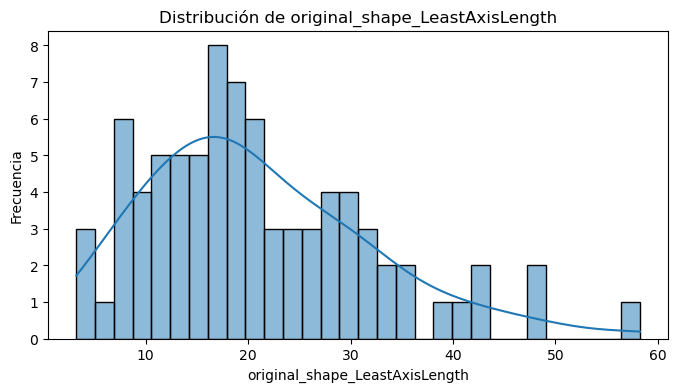

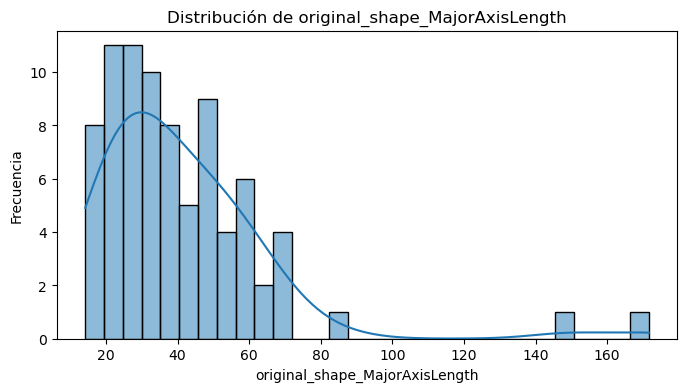

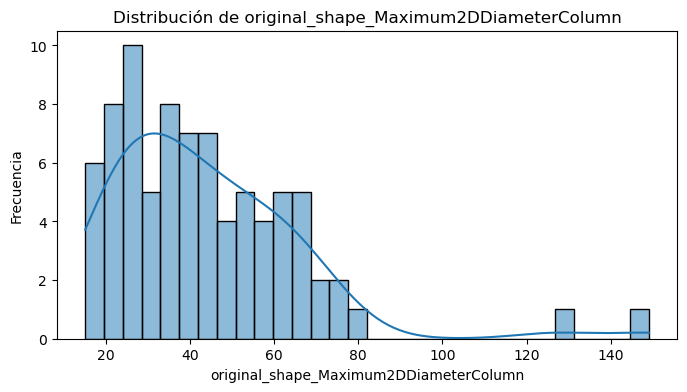

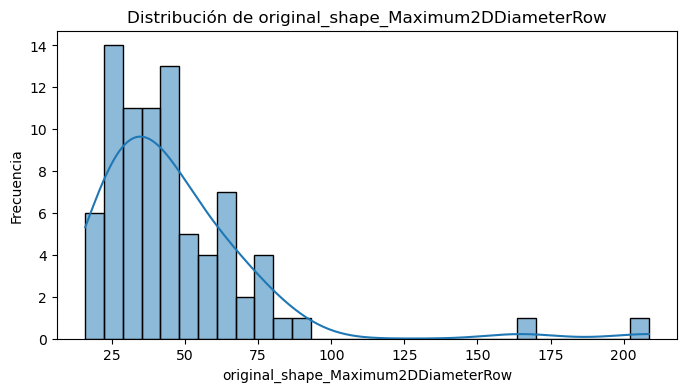

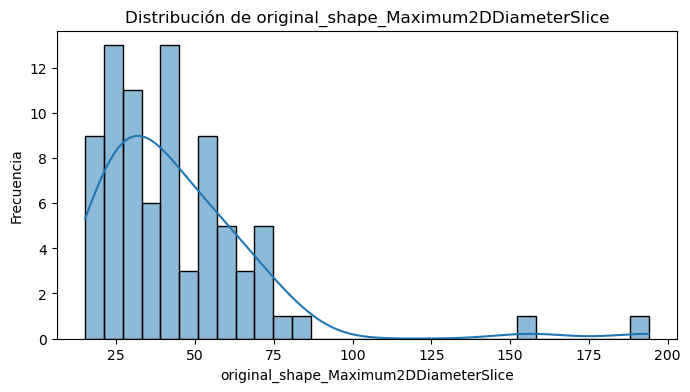

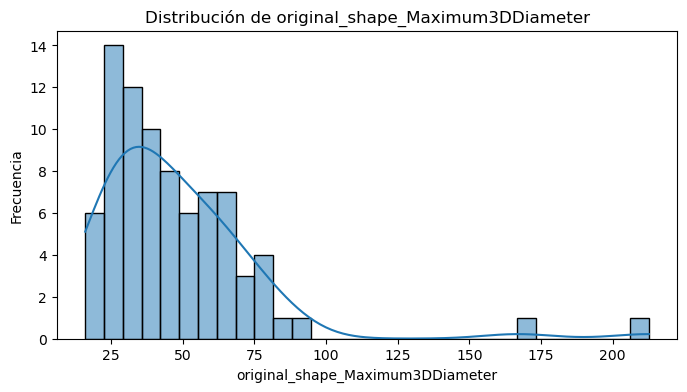

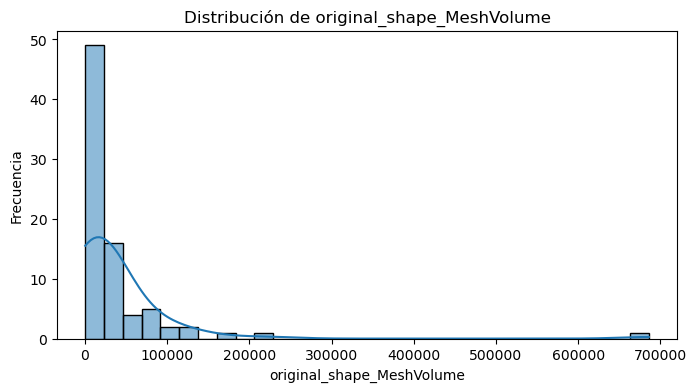

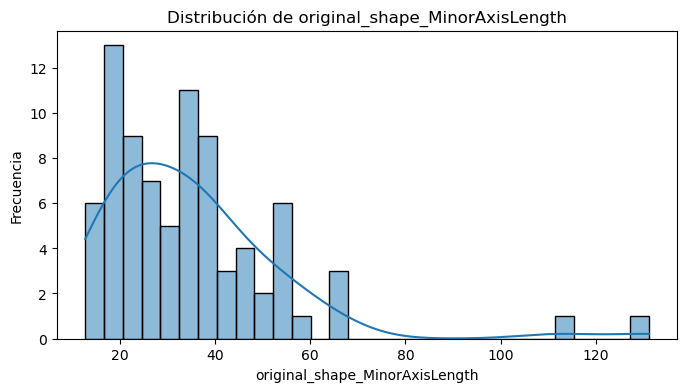

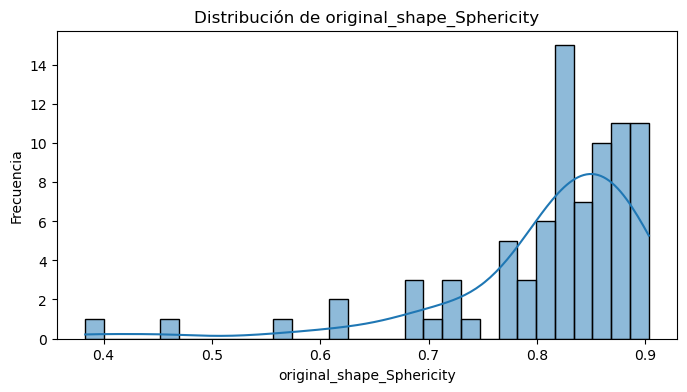

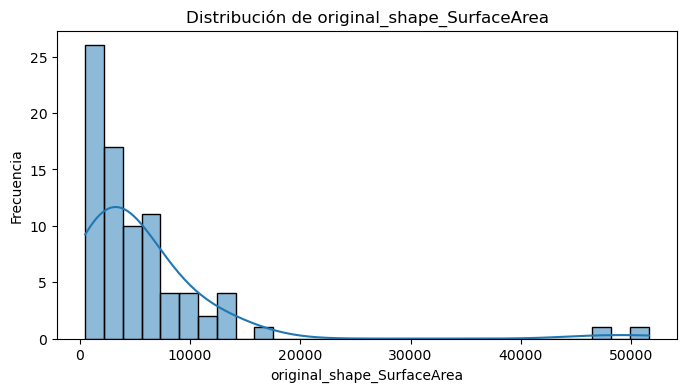

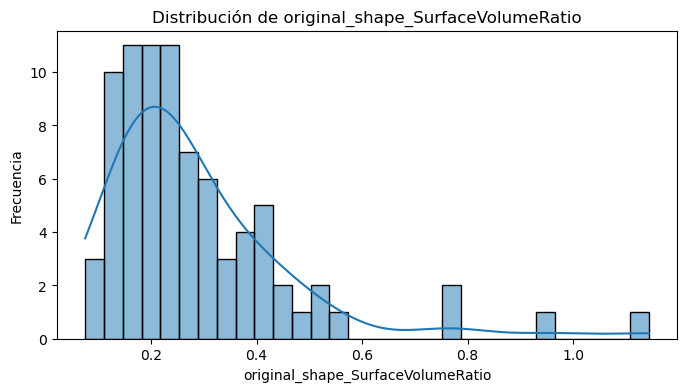

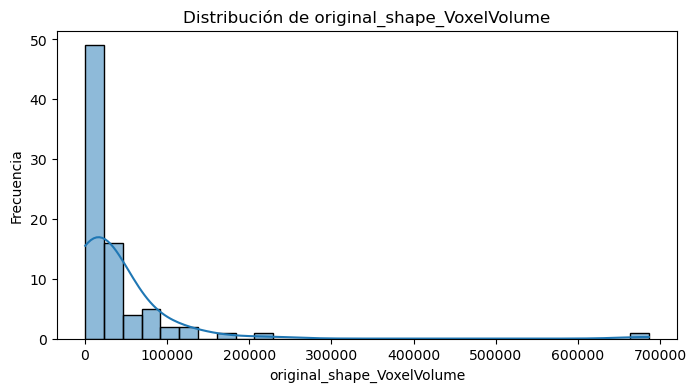

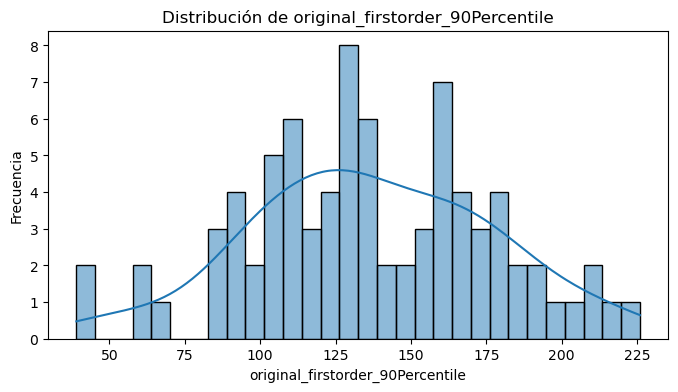

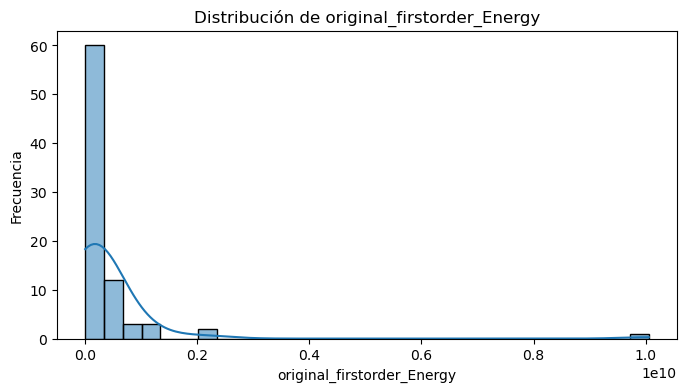

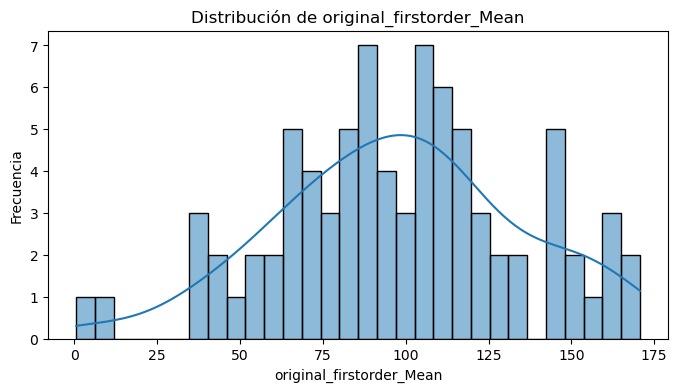

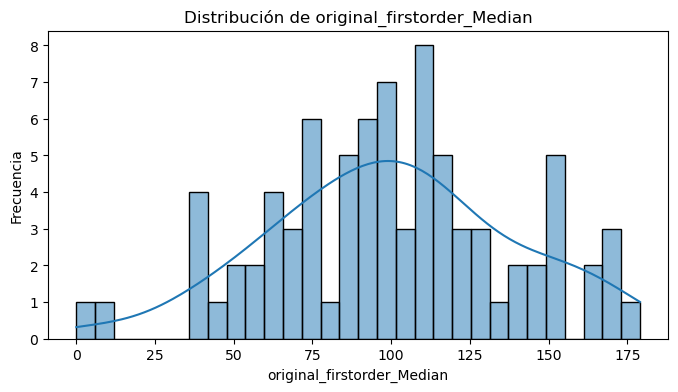

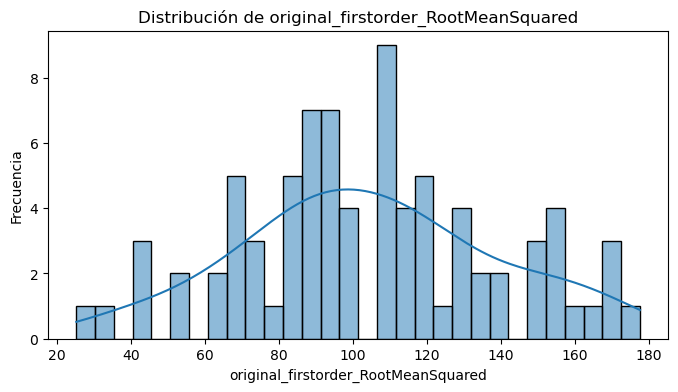

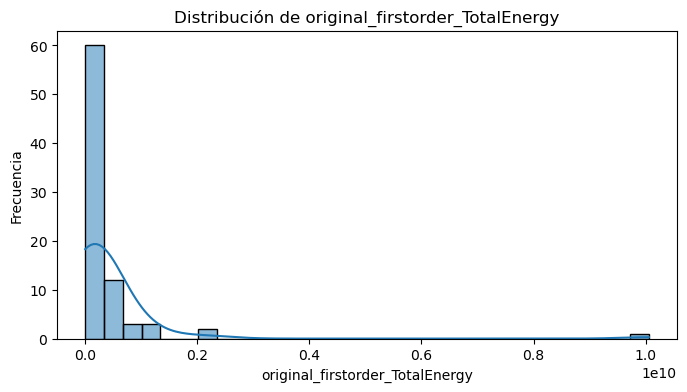

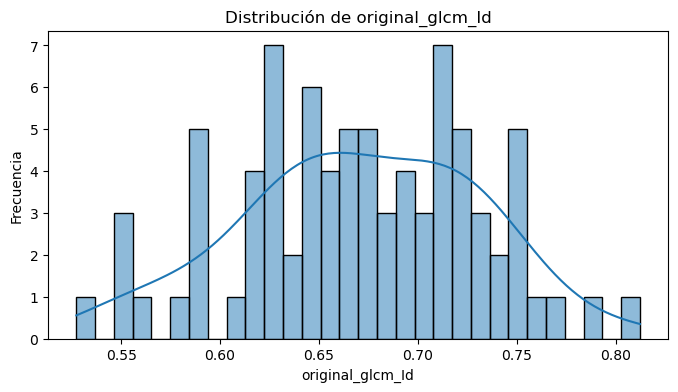

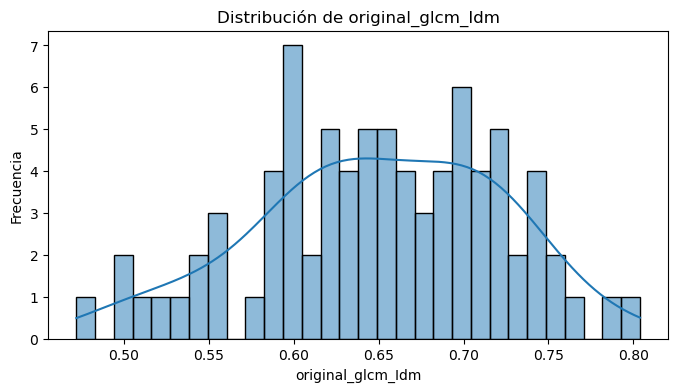

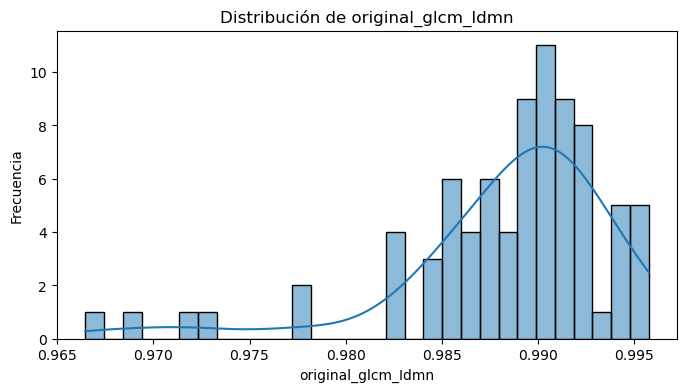

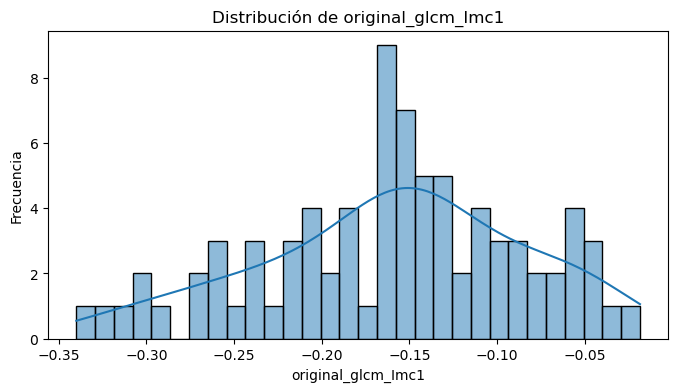

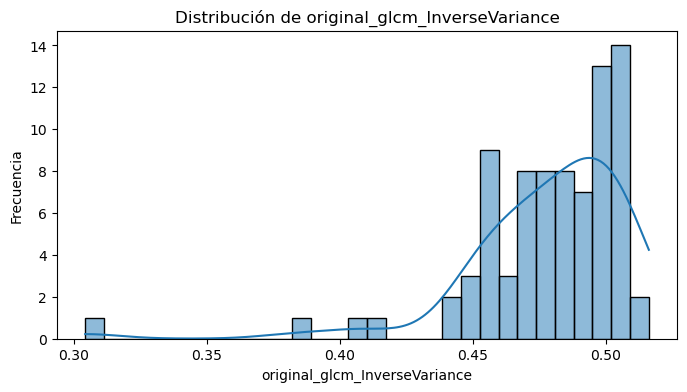

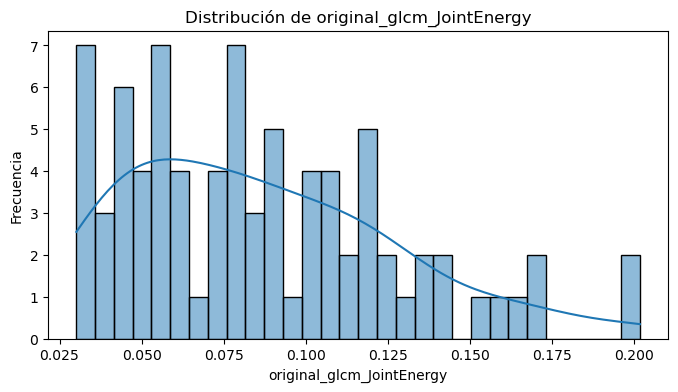

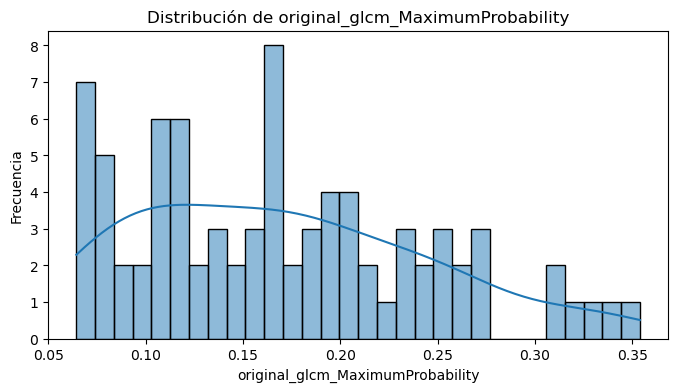

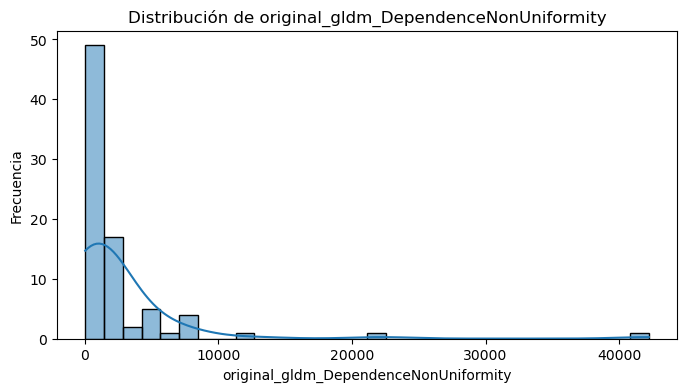

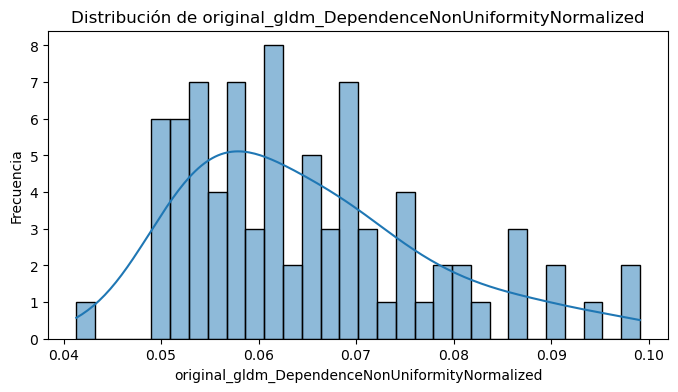

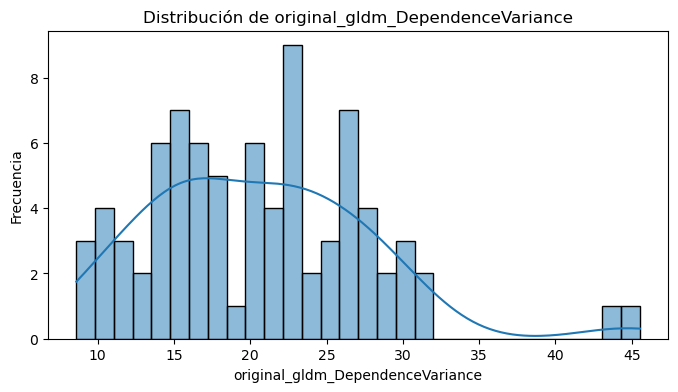

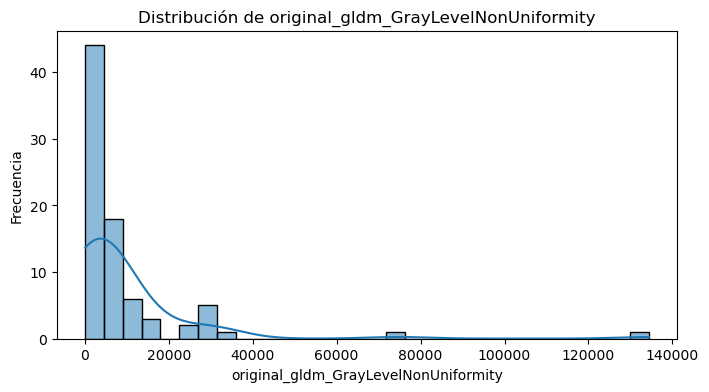

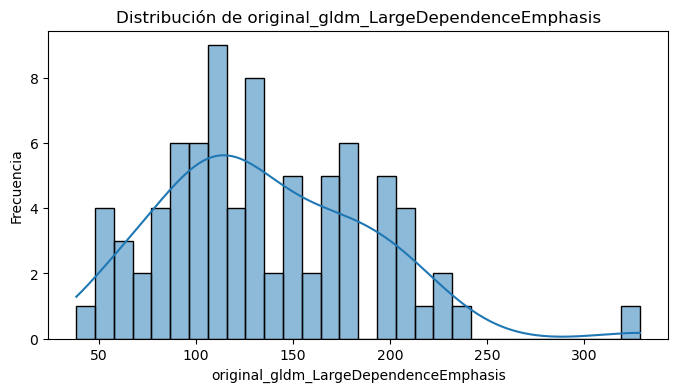

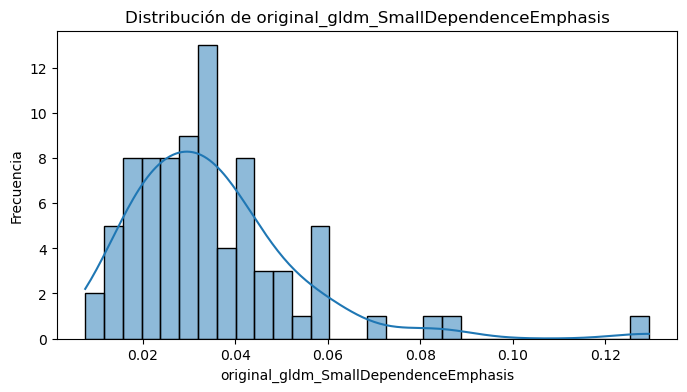

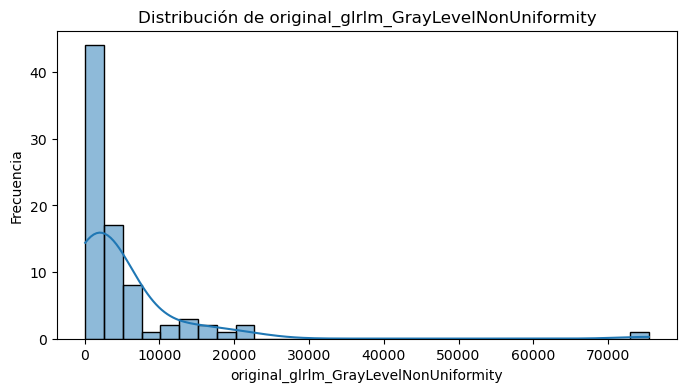

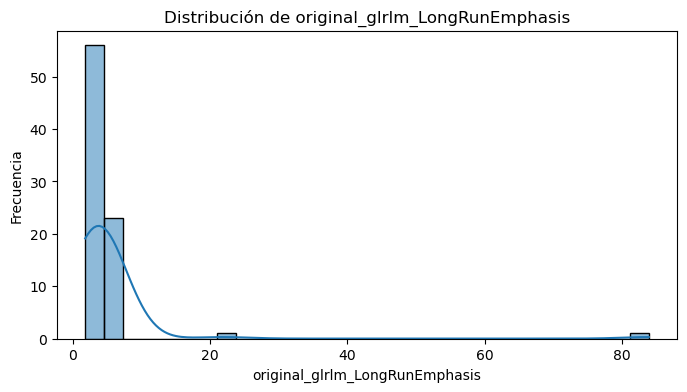

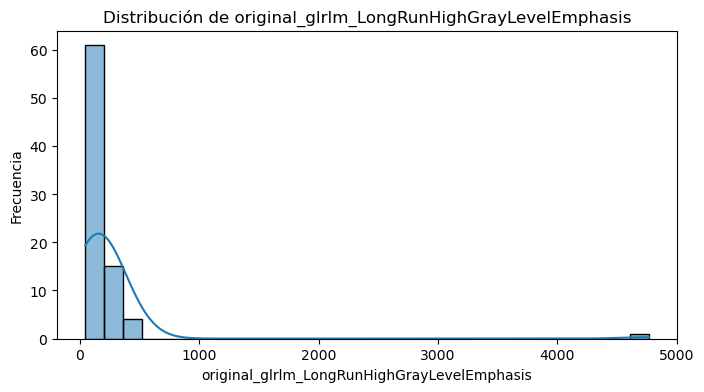

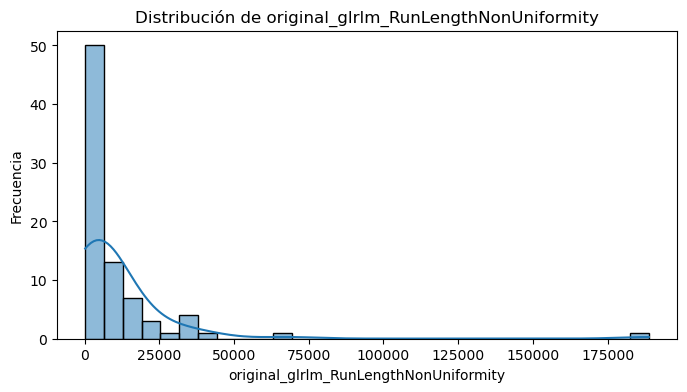

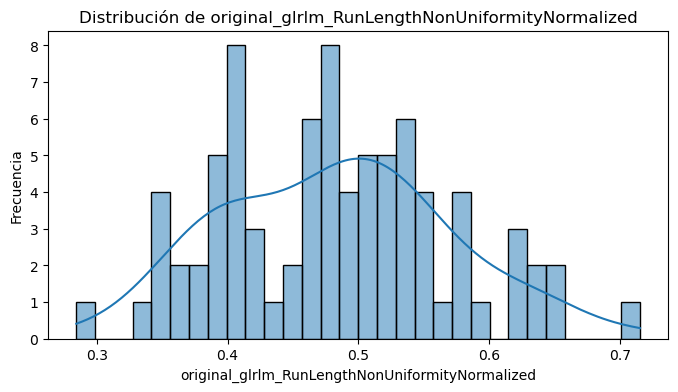

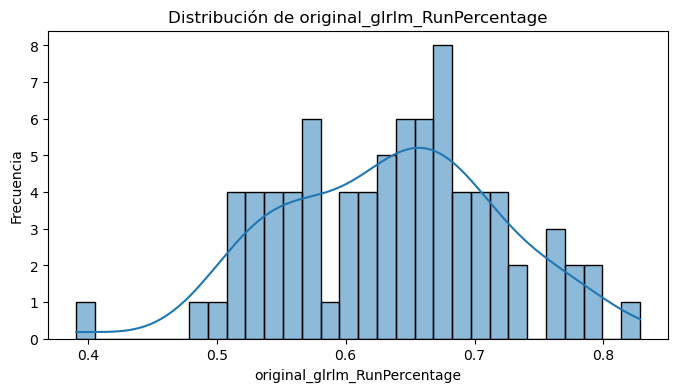

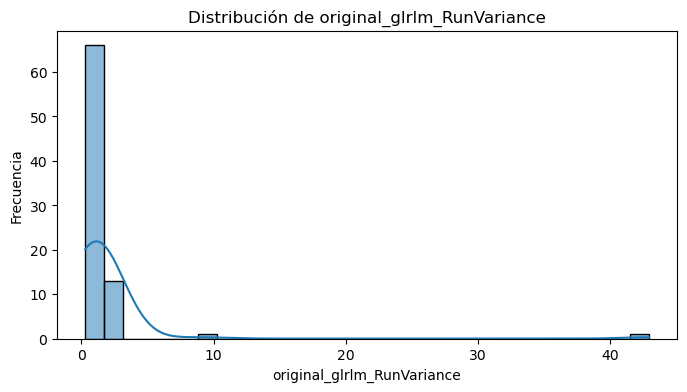

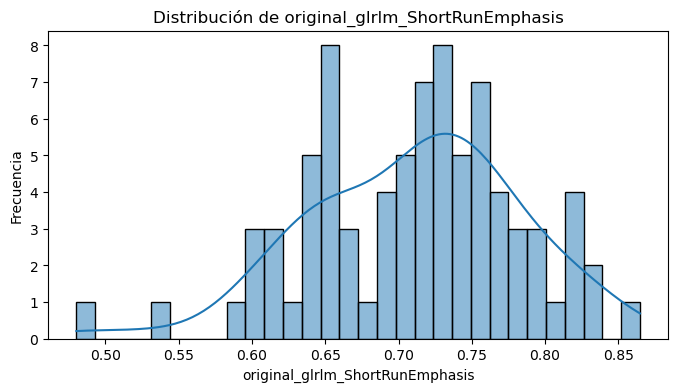

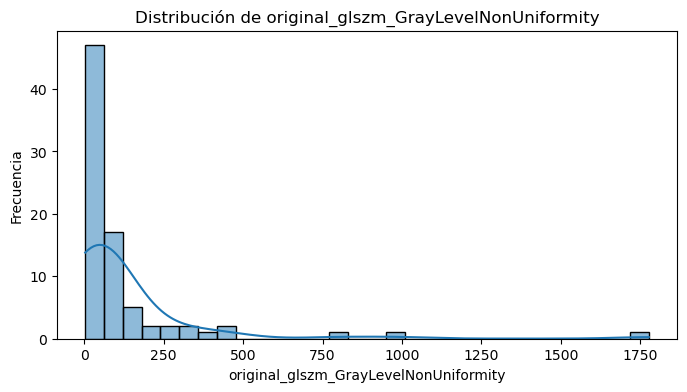

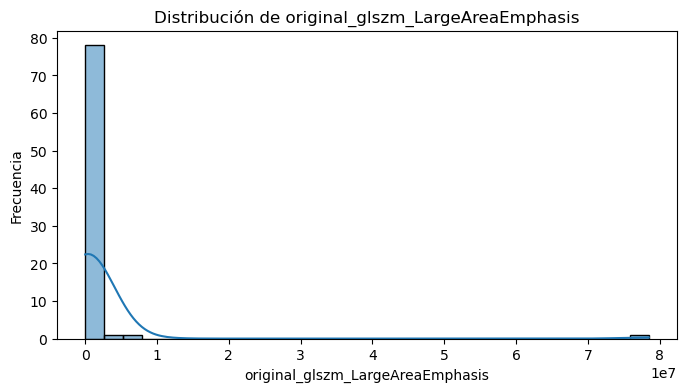

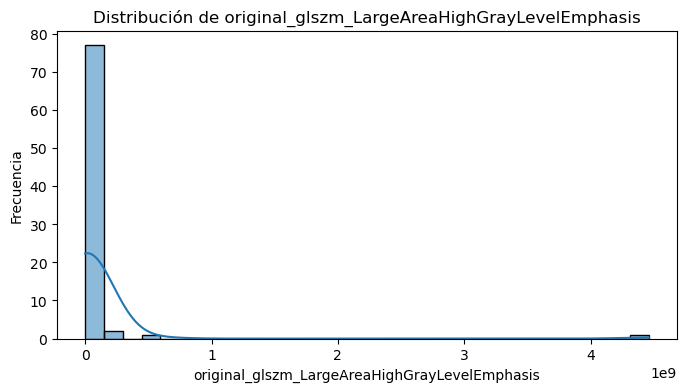

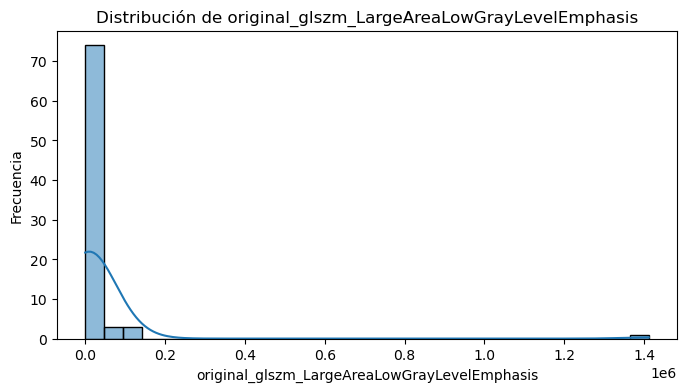

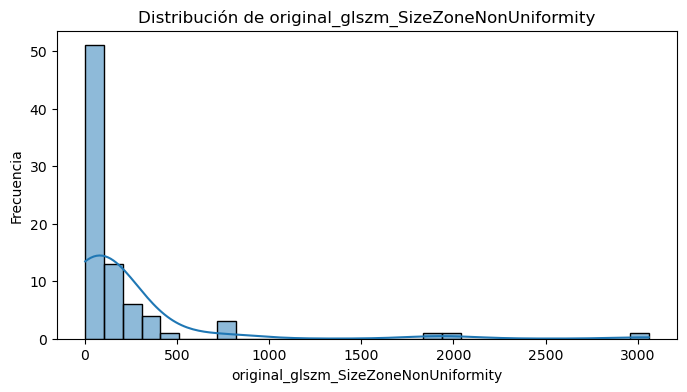

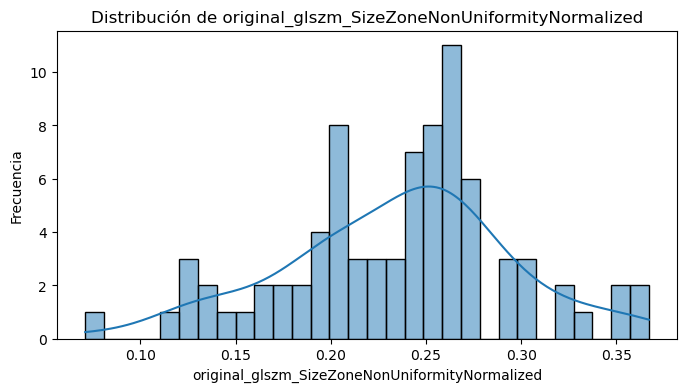

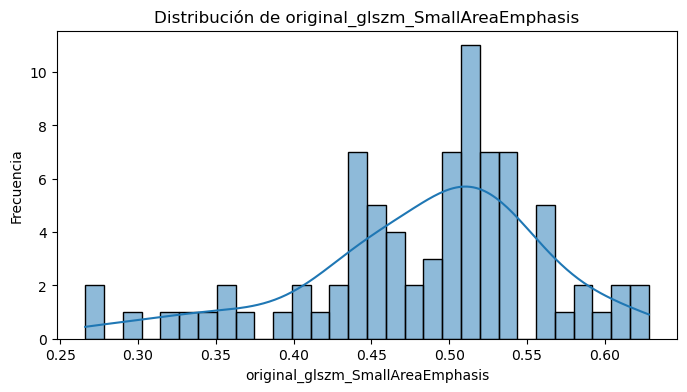

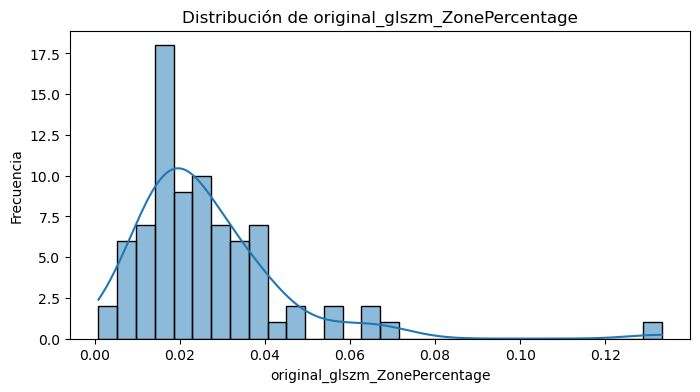

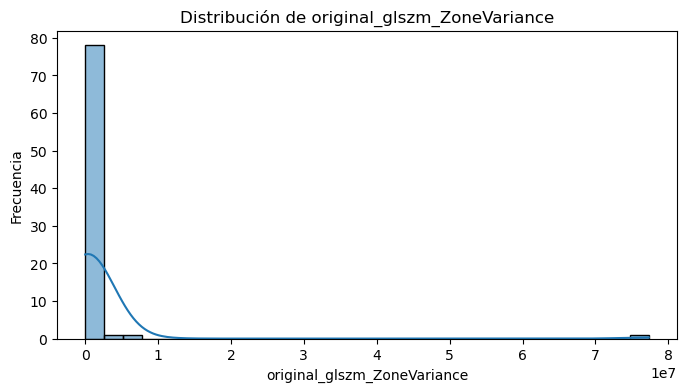

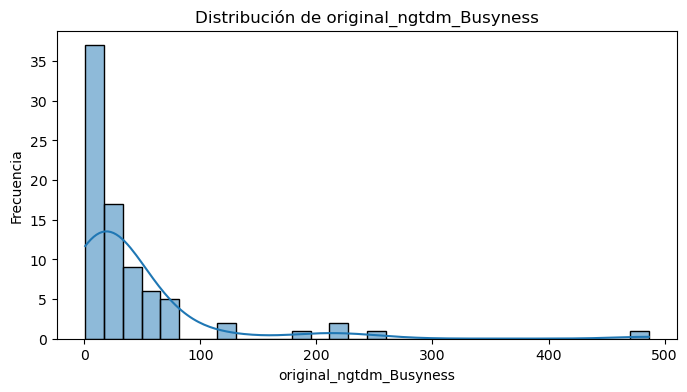

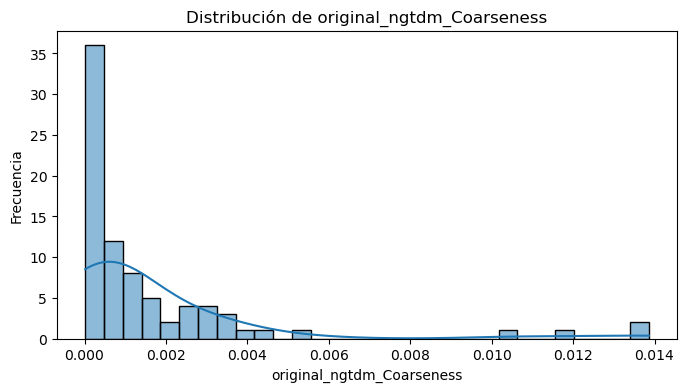

In [34]:
plot_variable_distribution(df_filt_reseg)

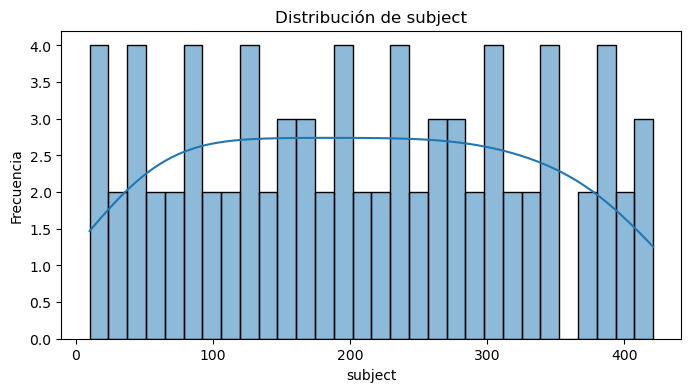

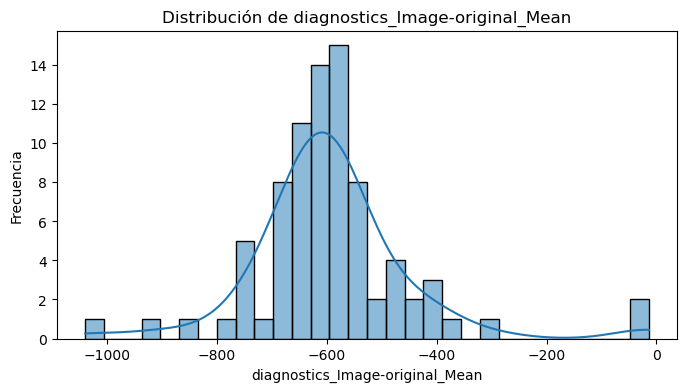

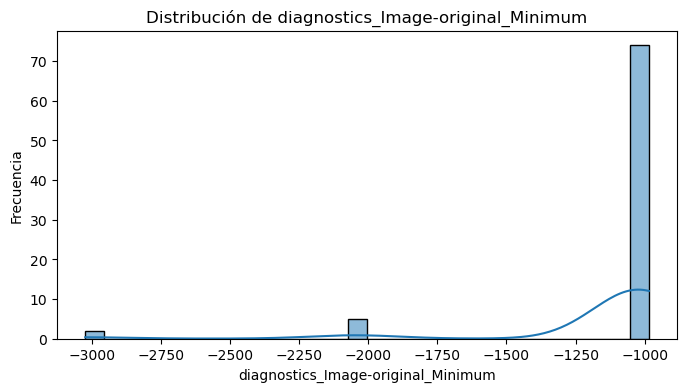

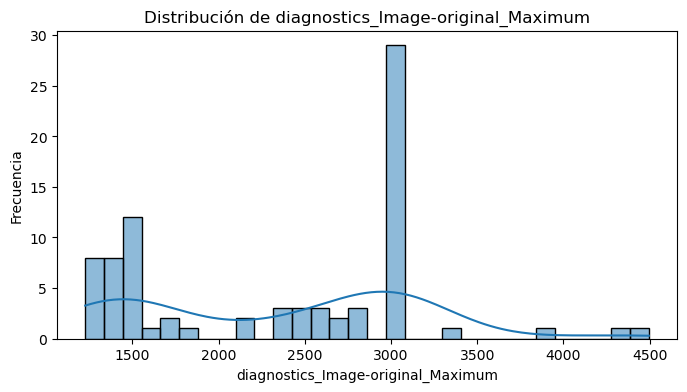

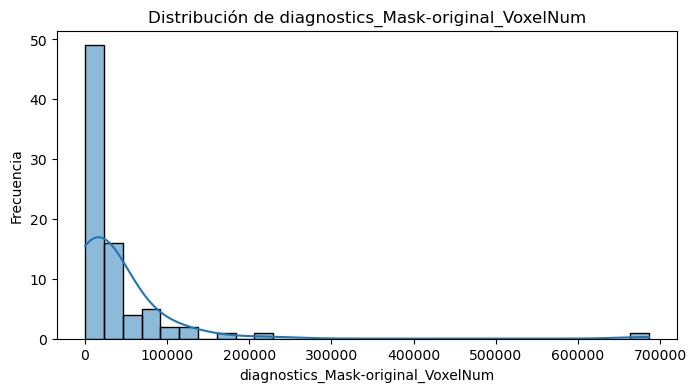

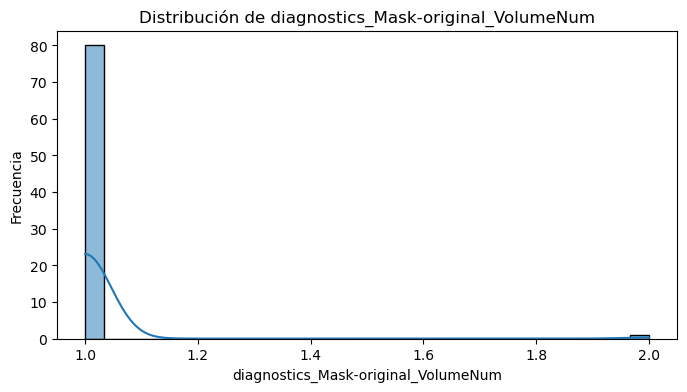

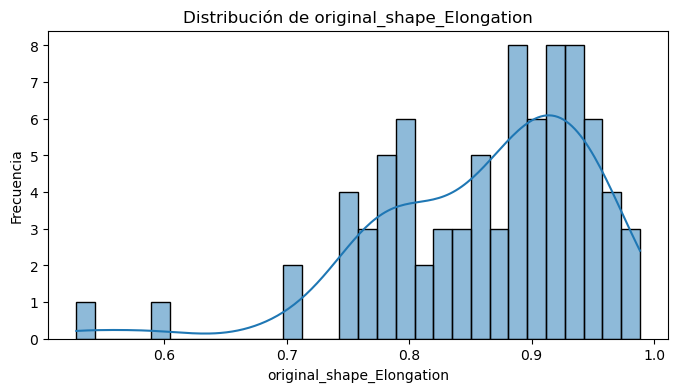

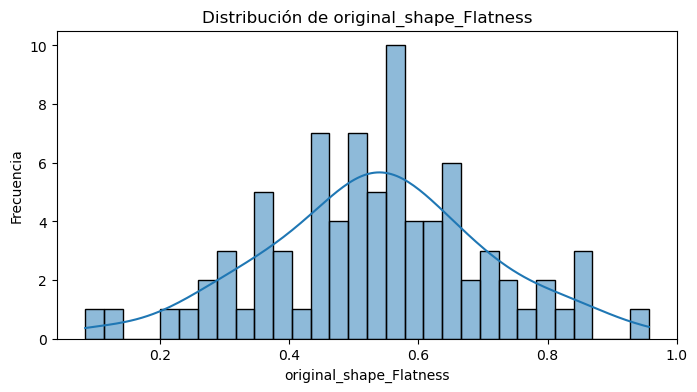

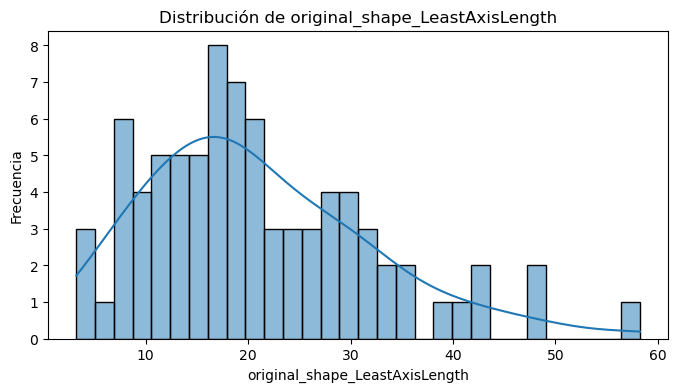

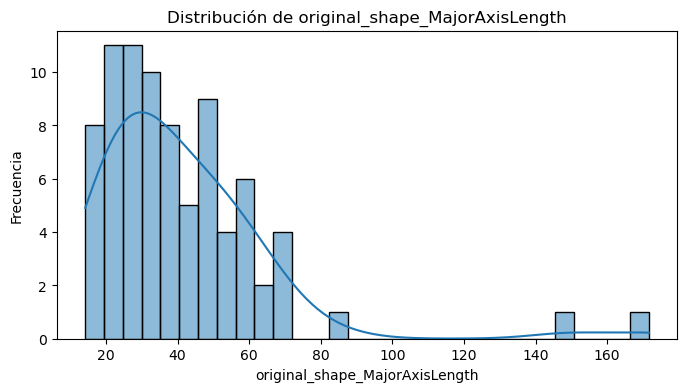

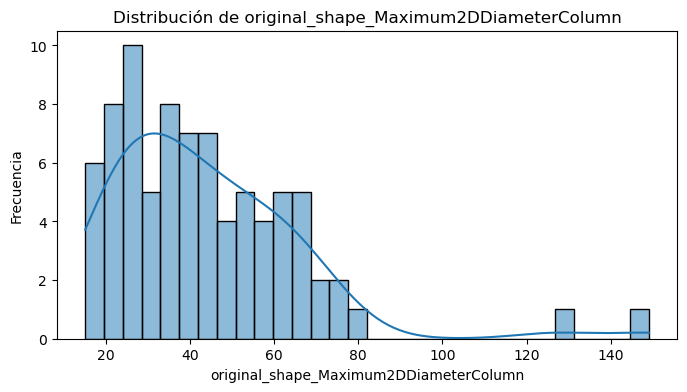

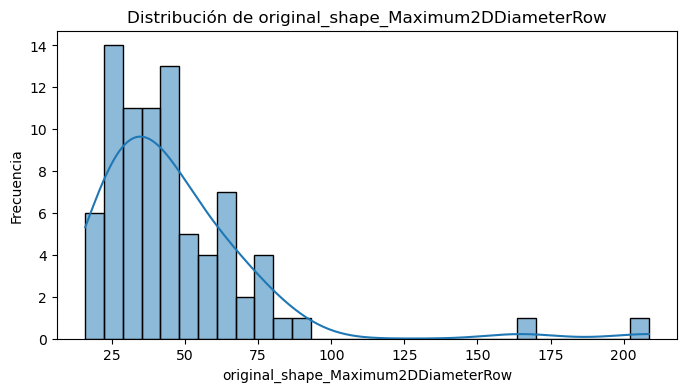

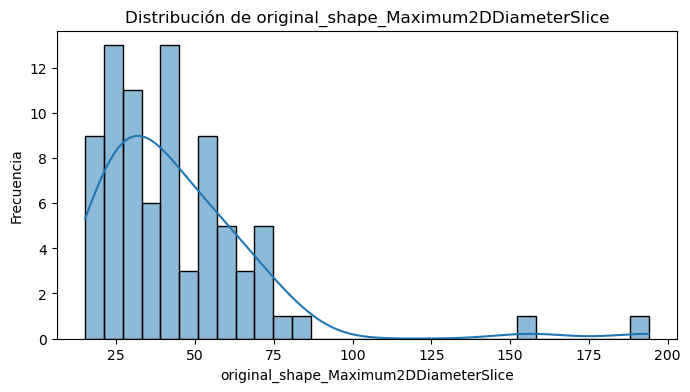

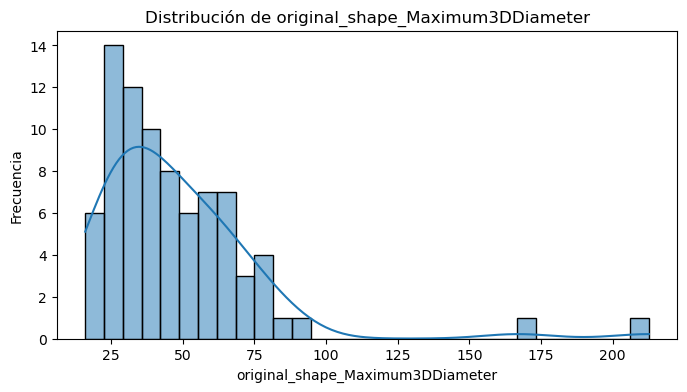

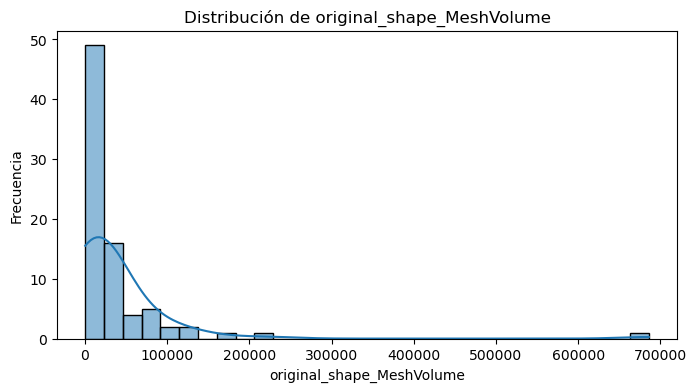

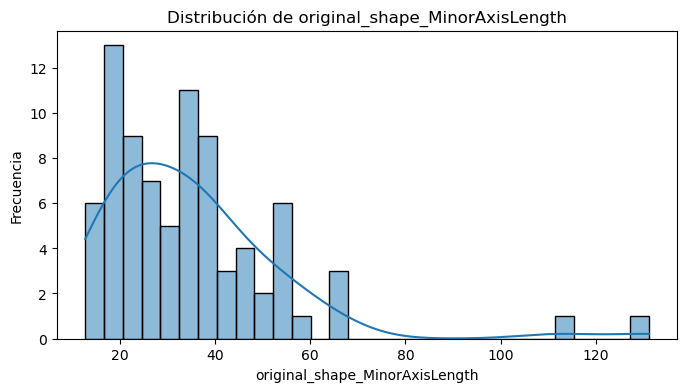

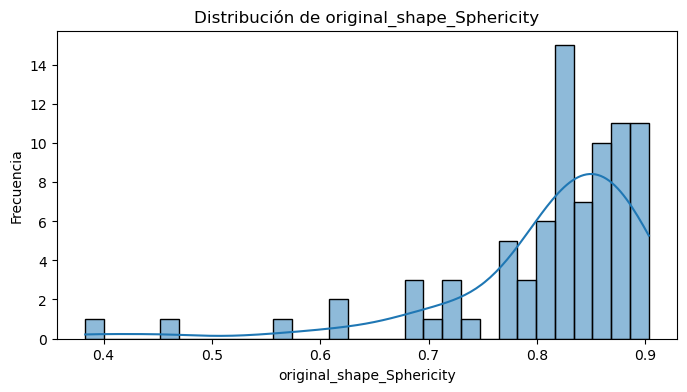

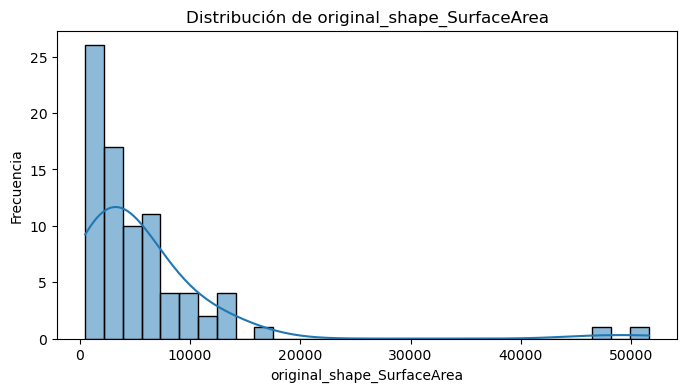

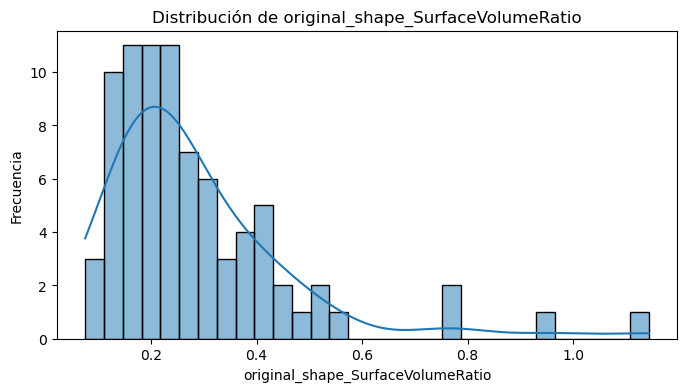

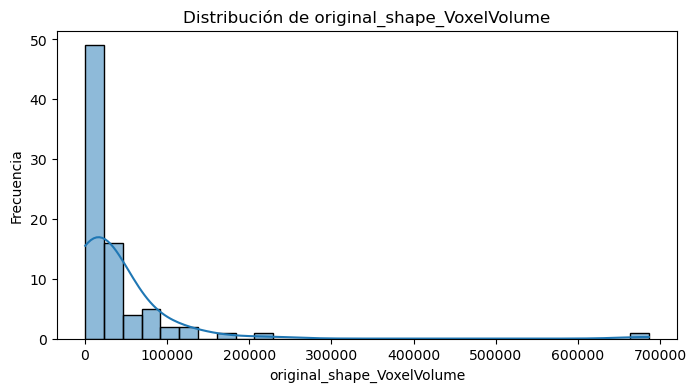

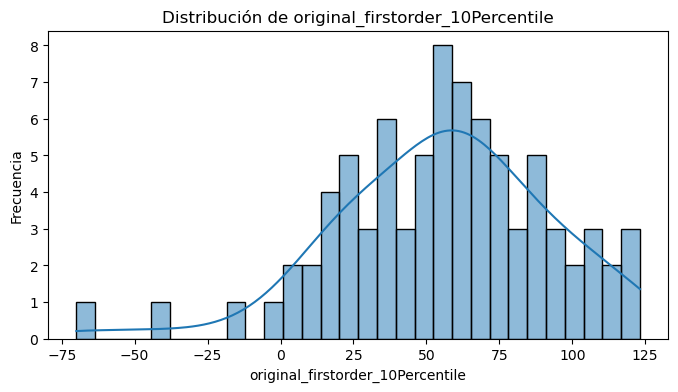

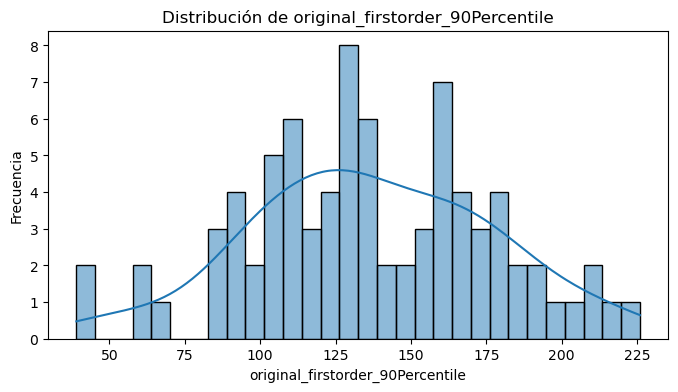

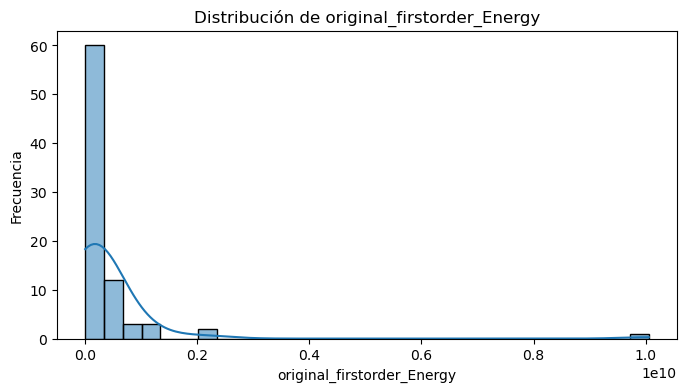

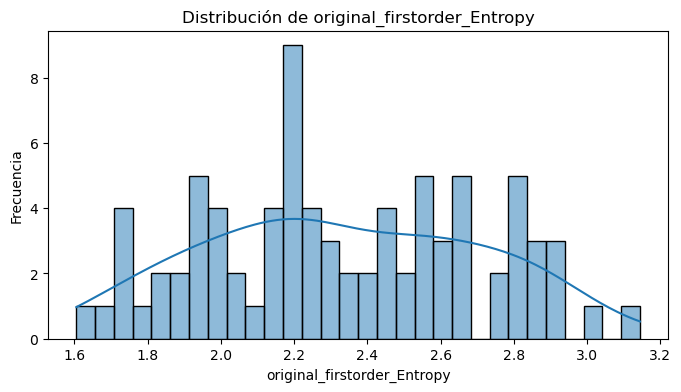

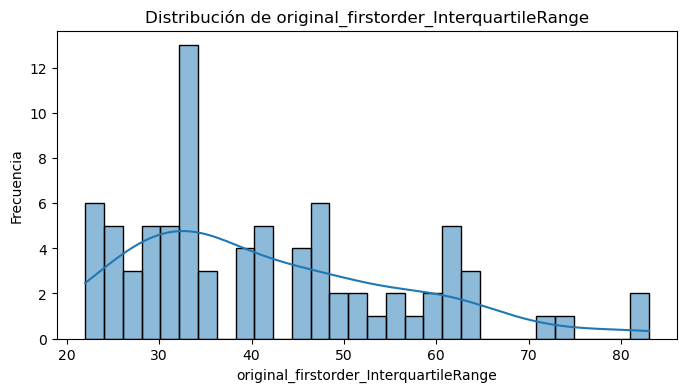

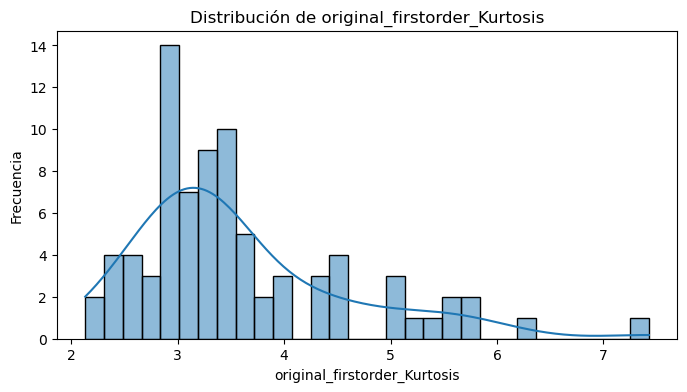

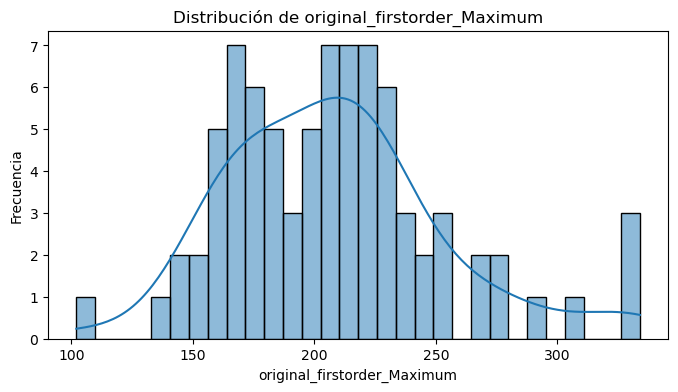

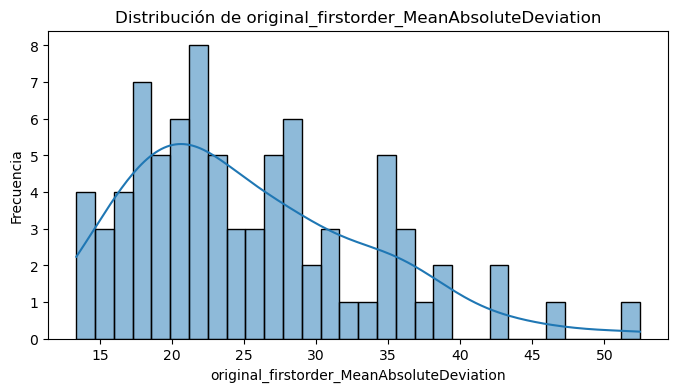

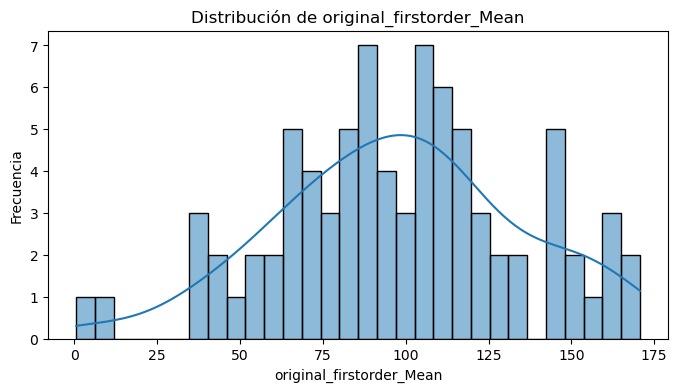

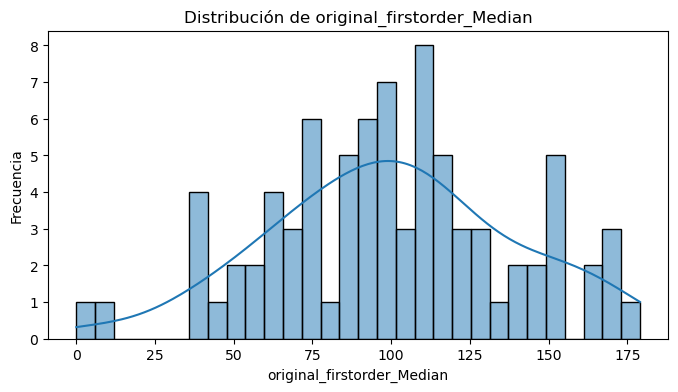

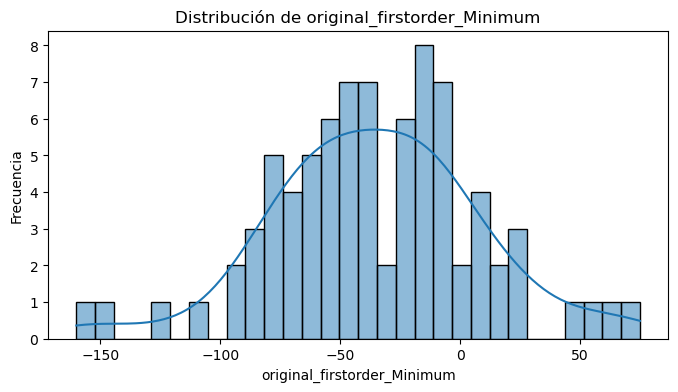

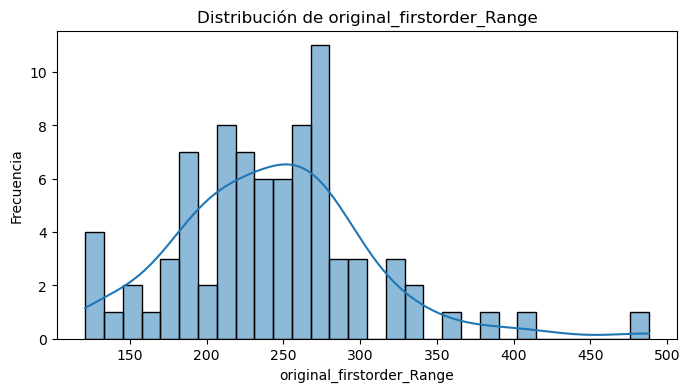

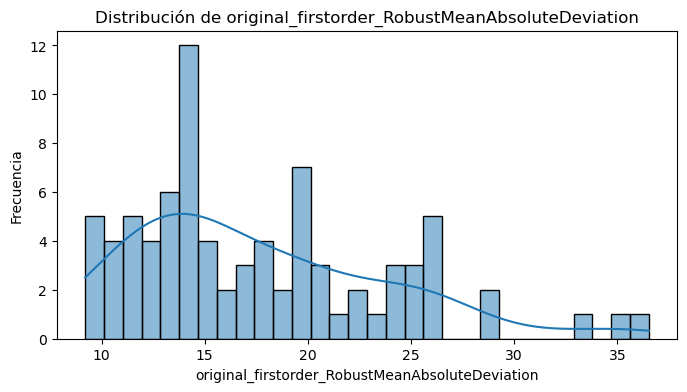

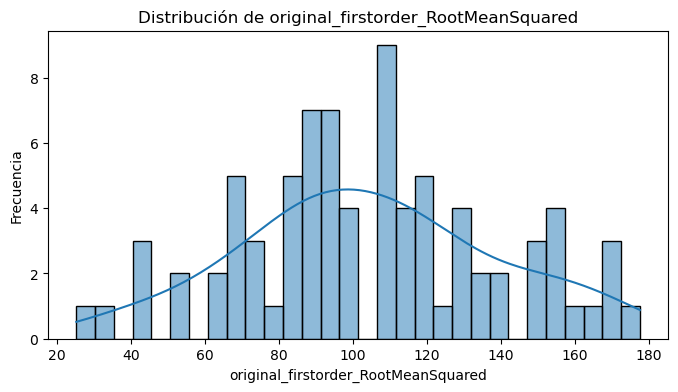

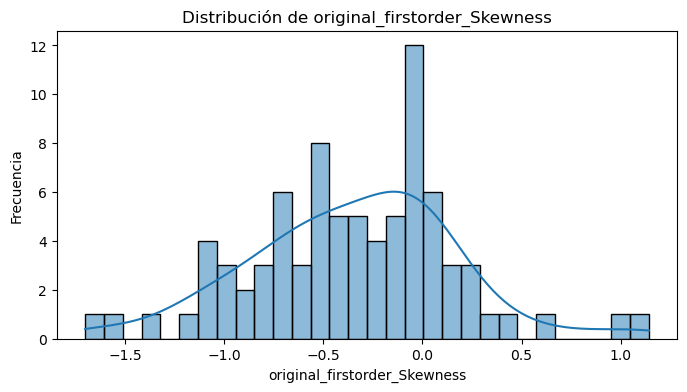

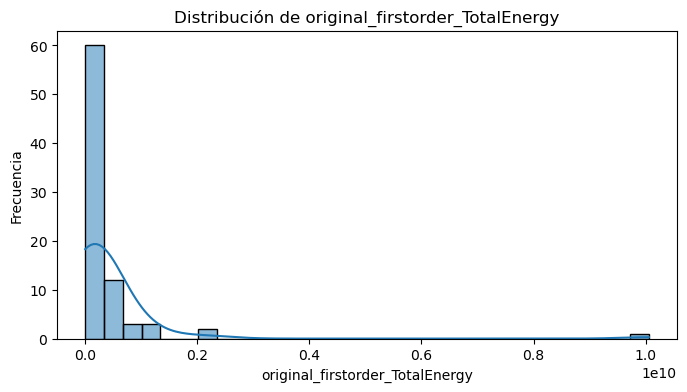

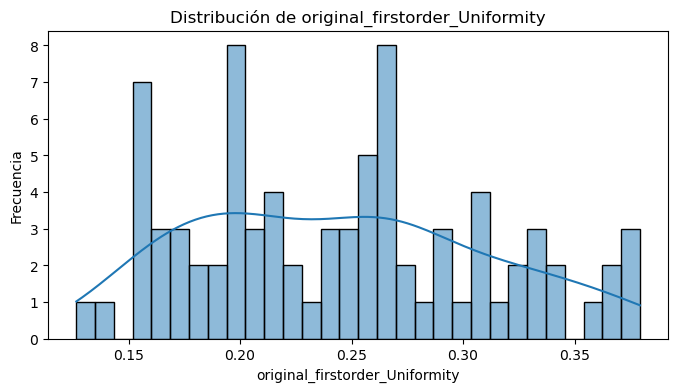

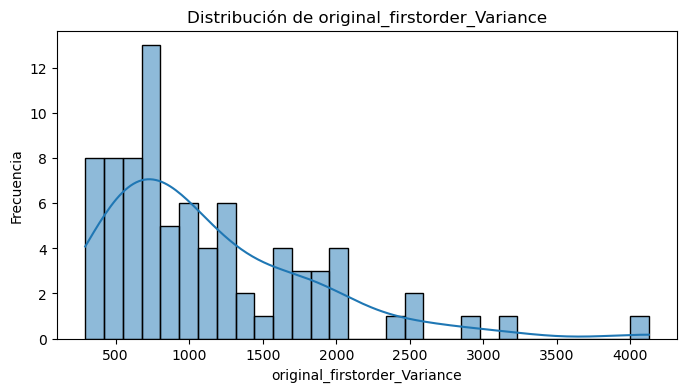

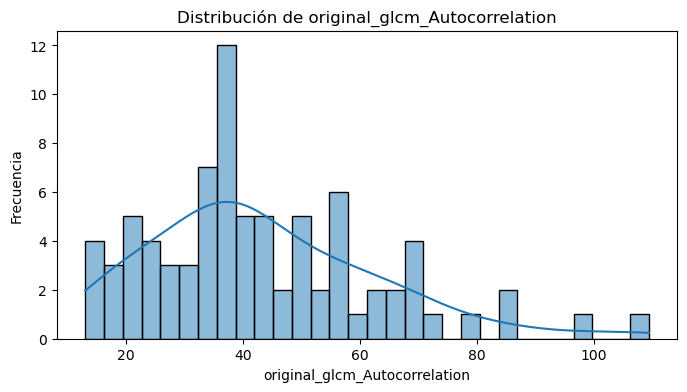

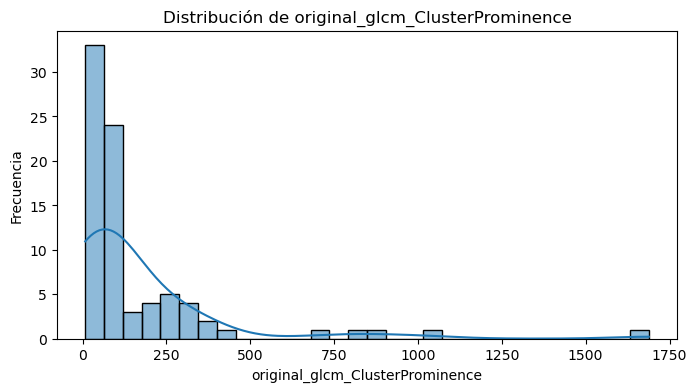

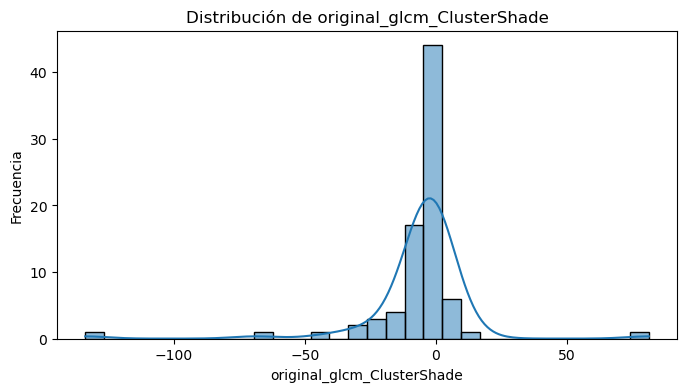

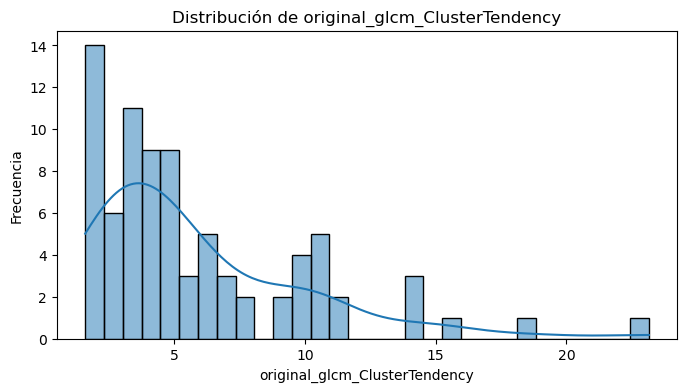

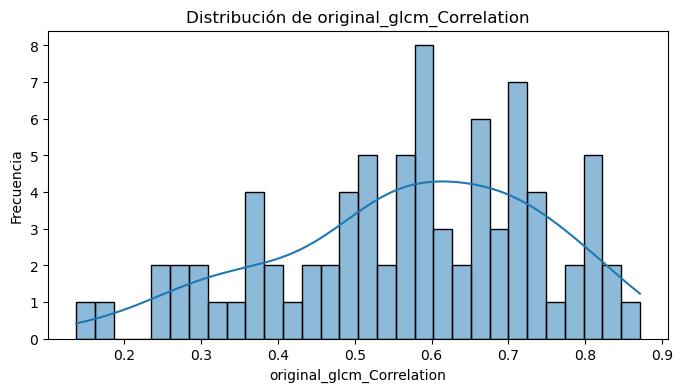

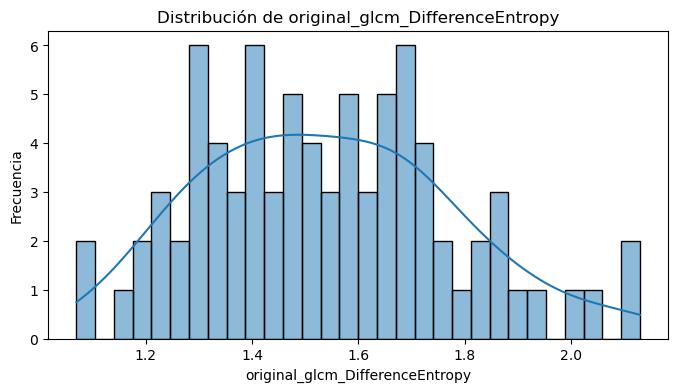

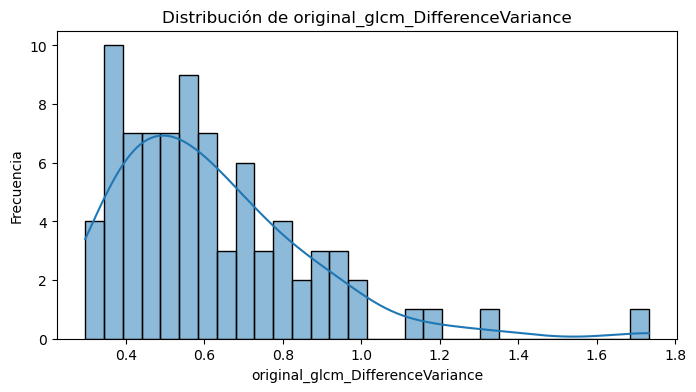

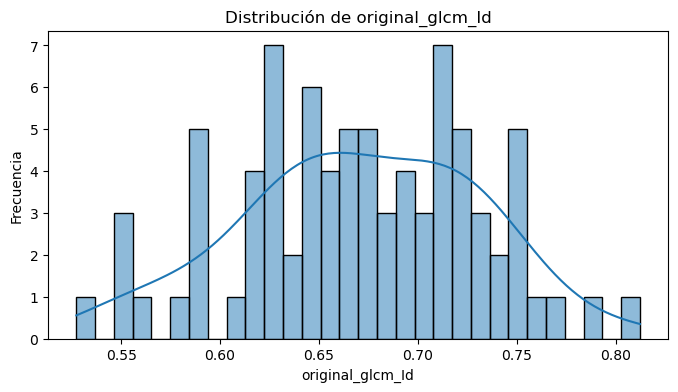

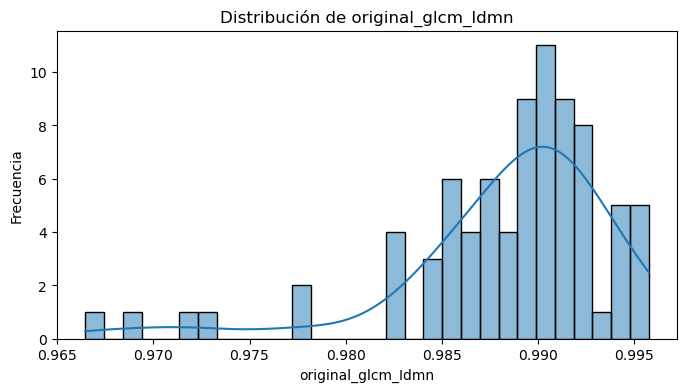

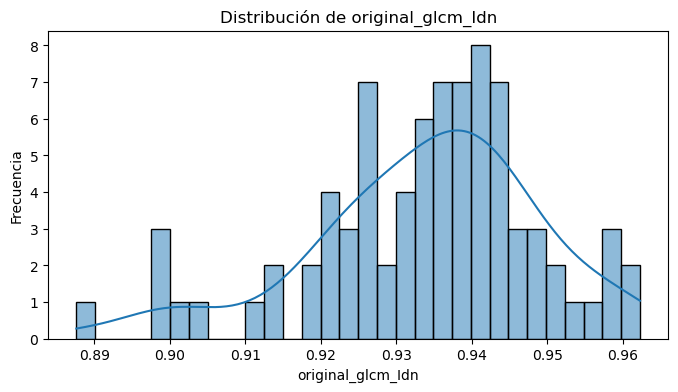

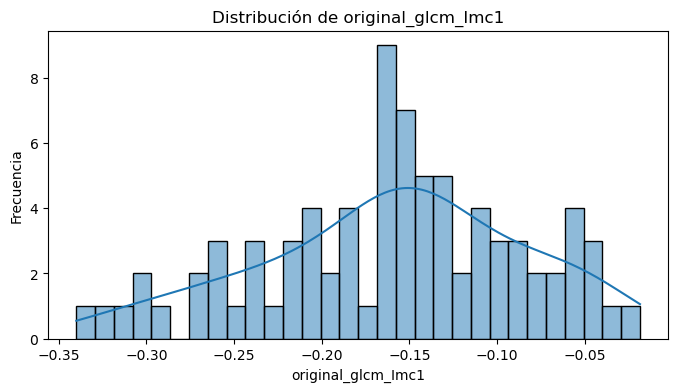

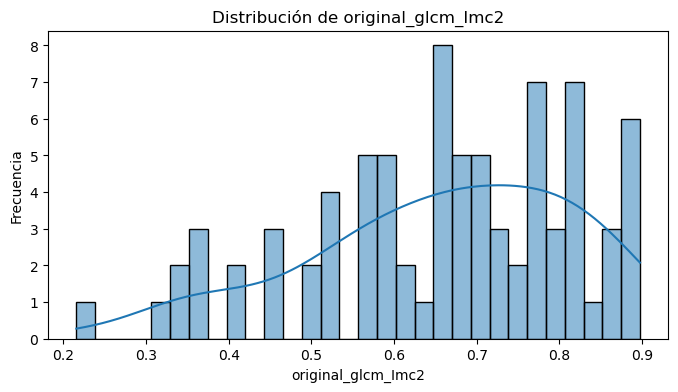

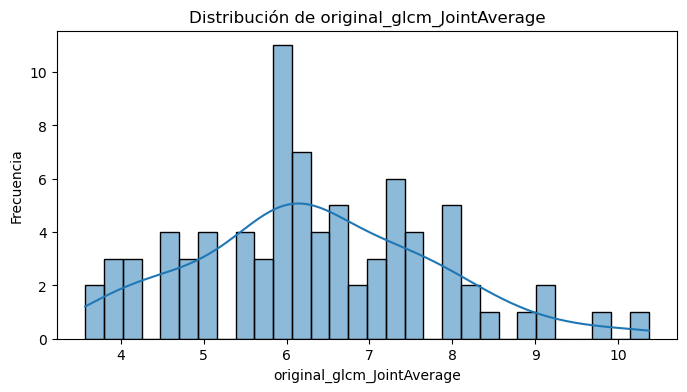

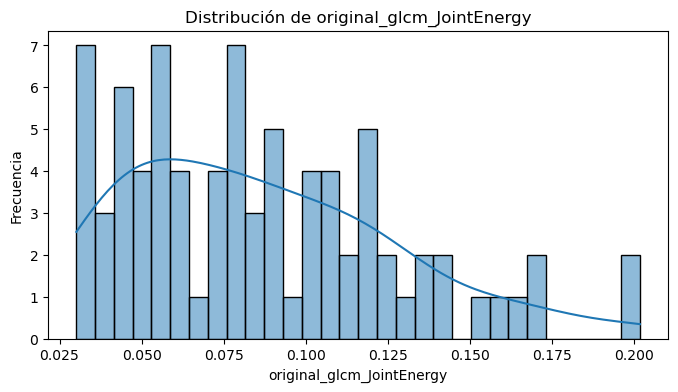

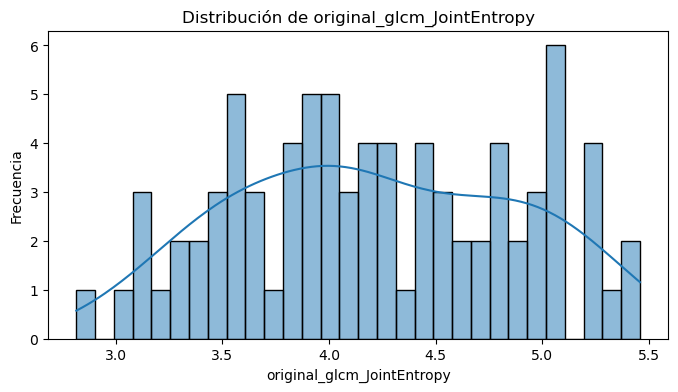

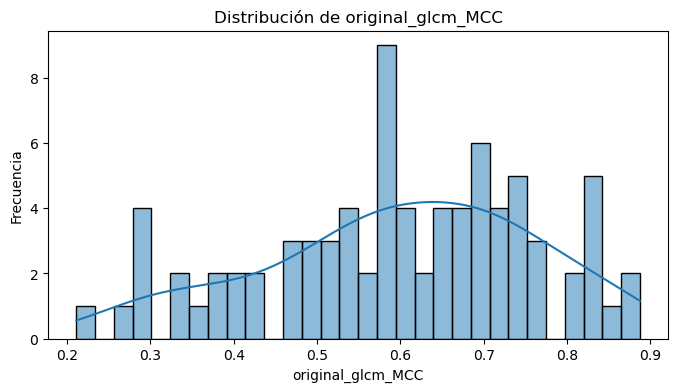

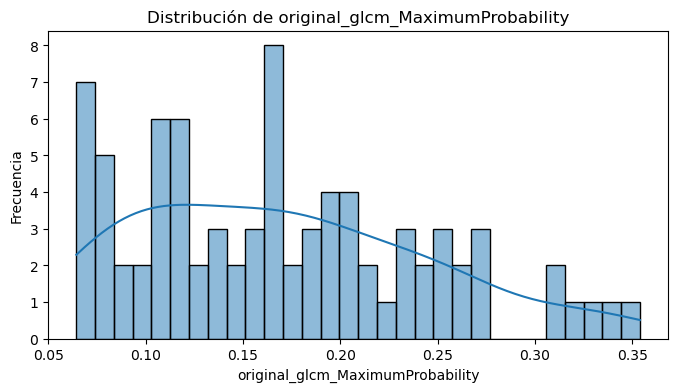

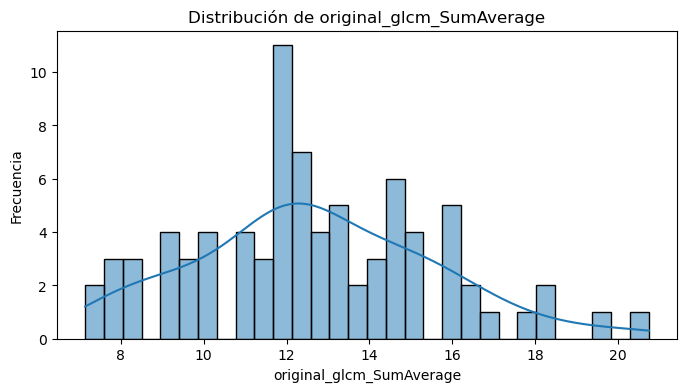

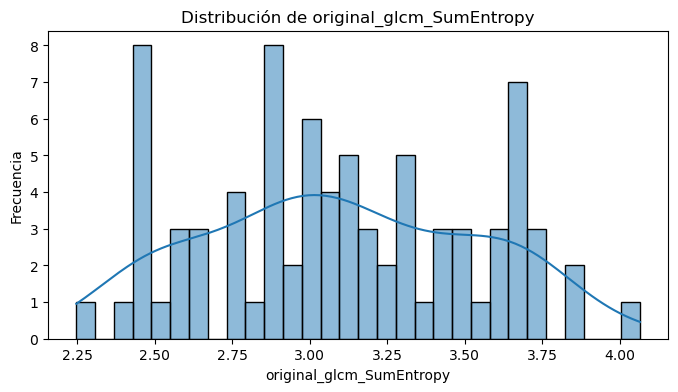

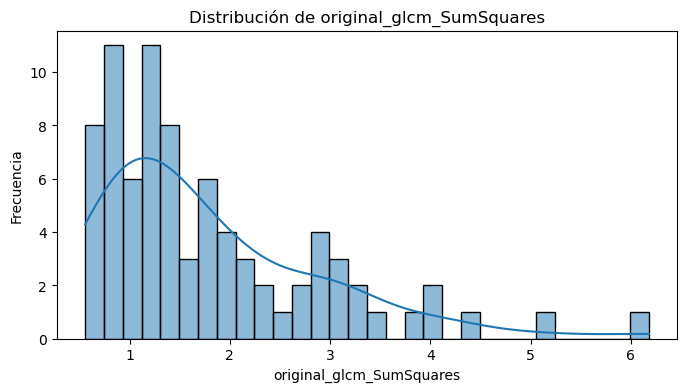

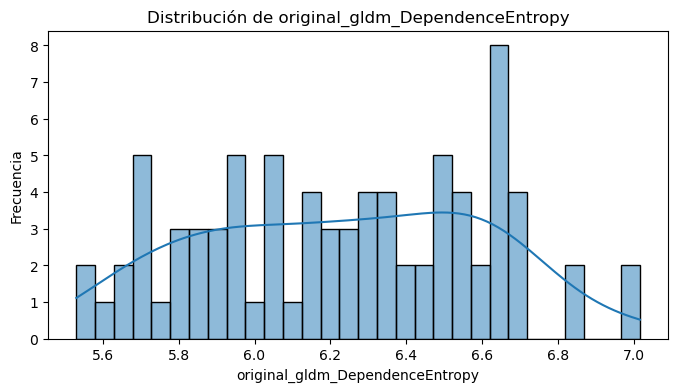

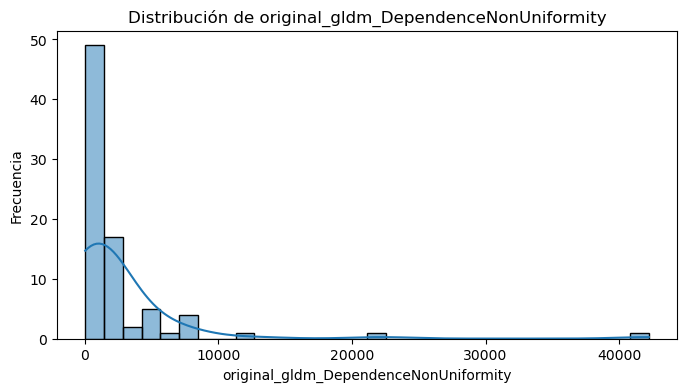

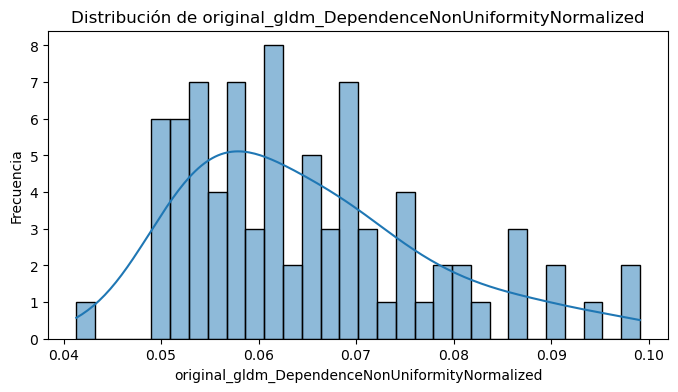

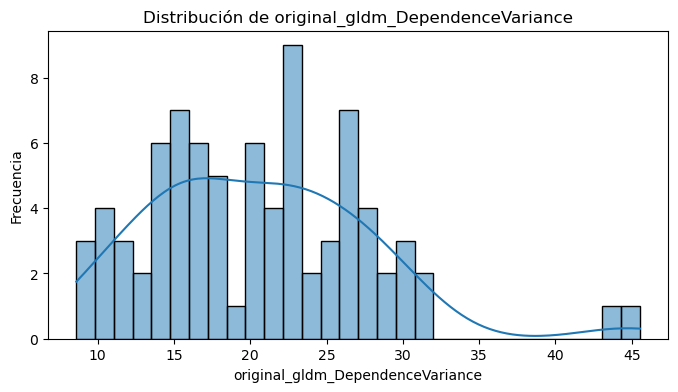

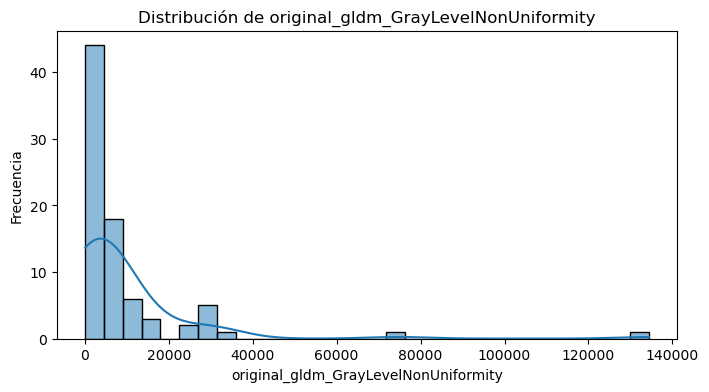

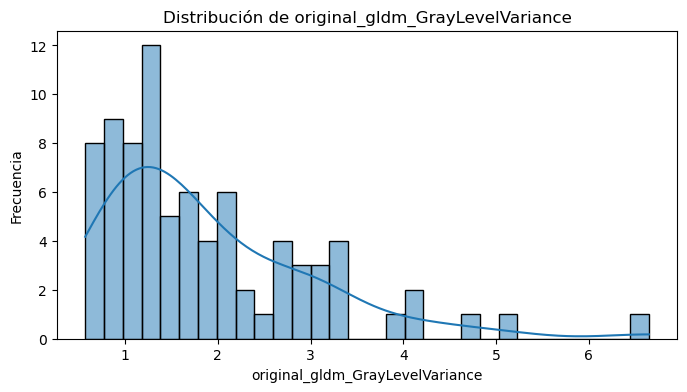

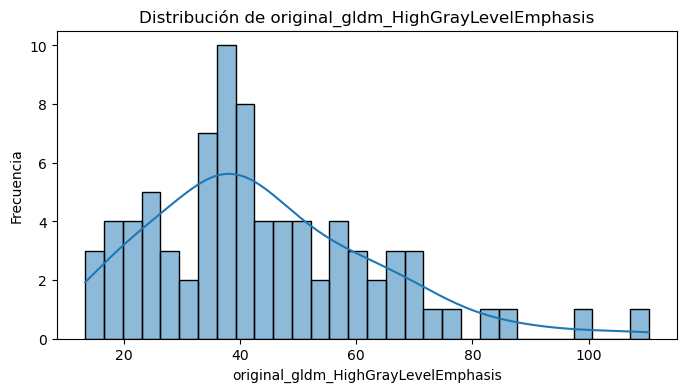

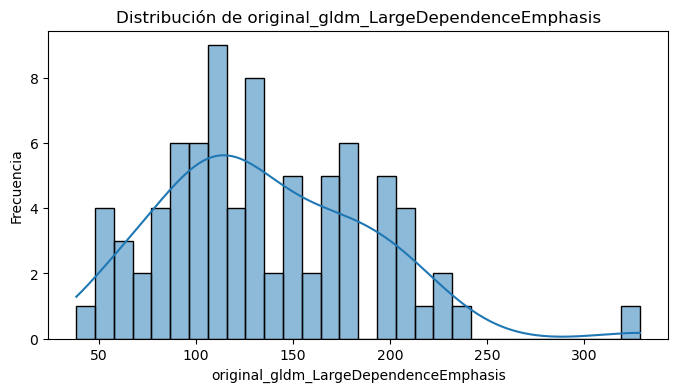

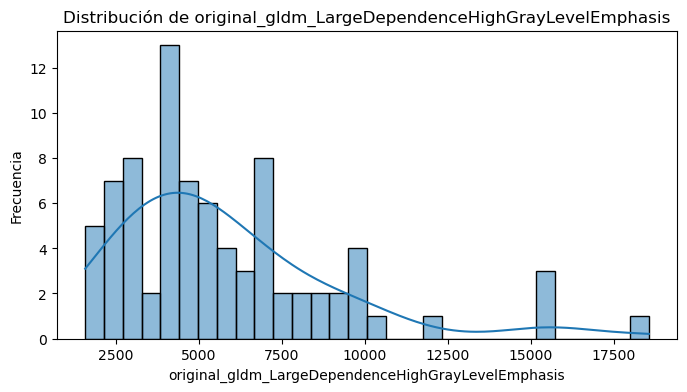

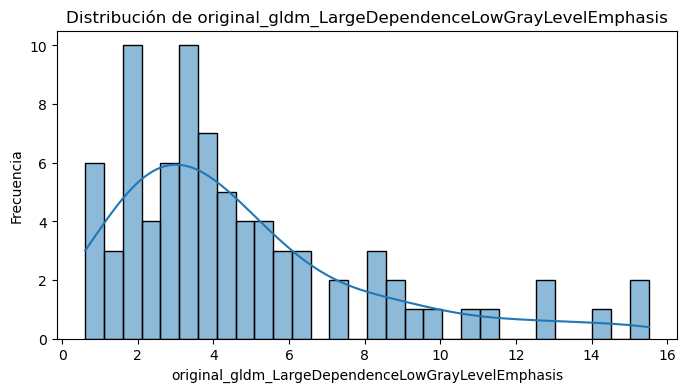

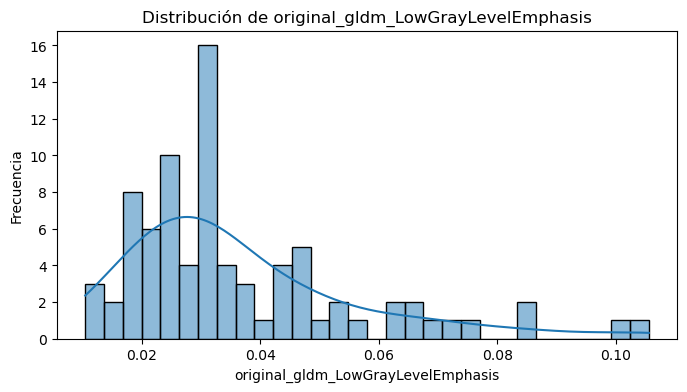

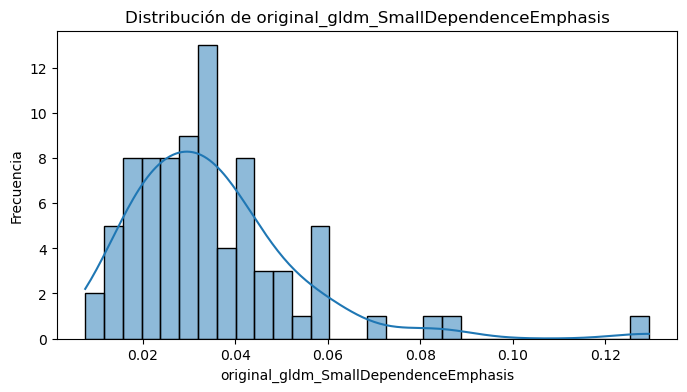

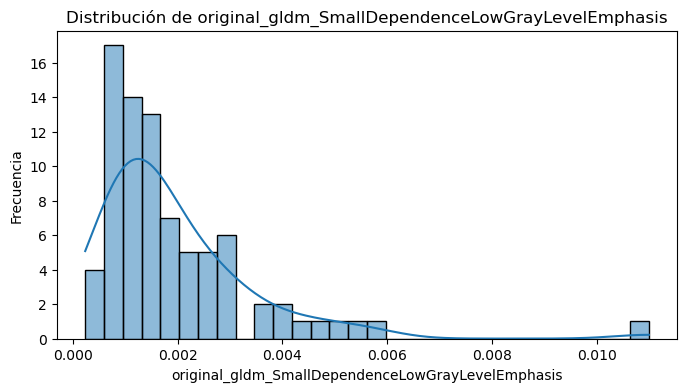

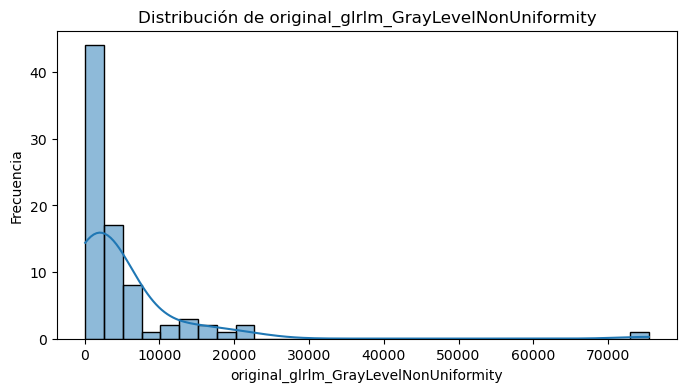

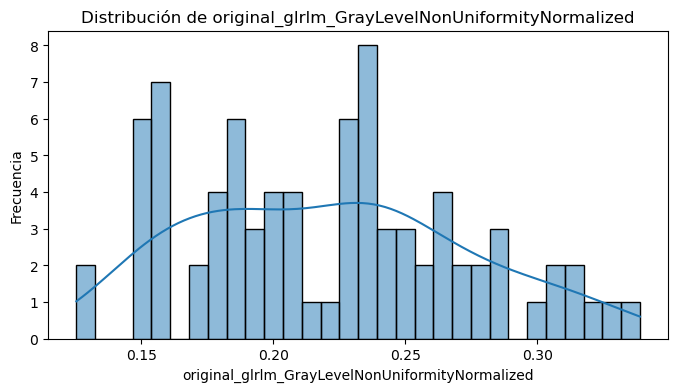

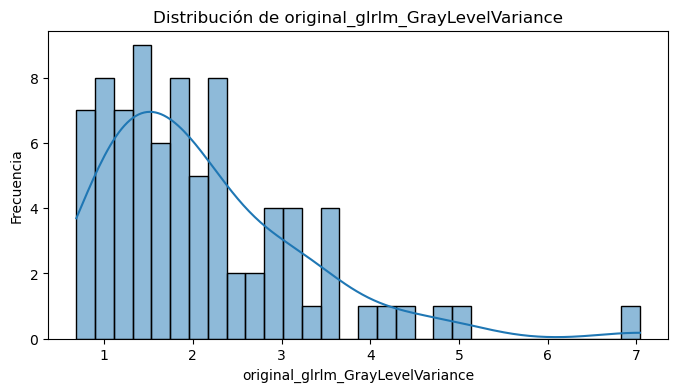

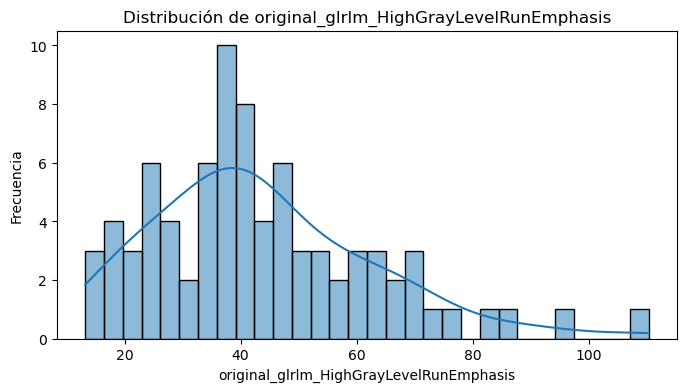

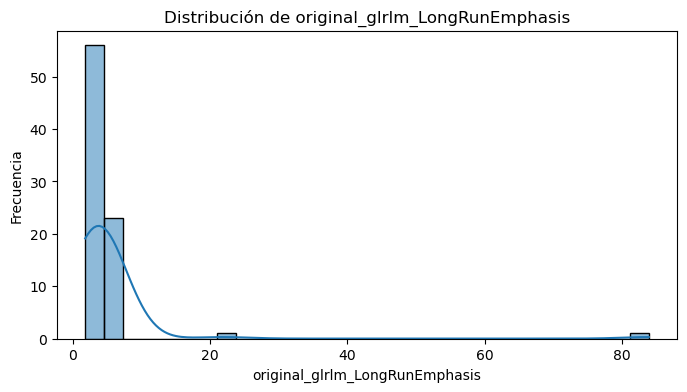

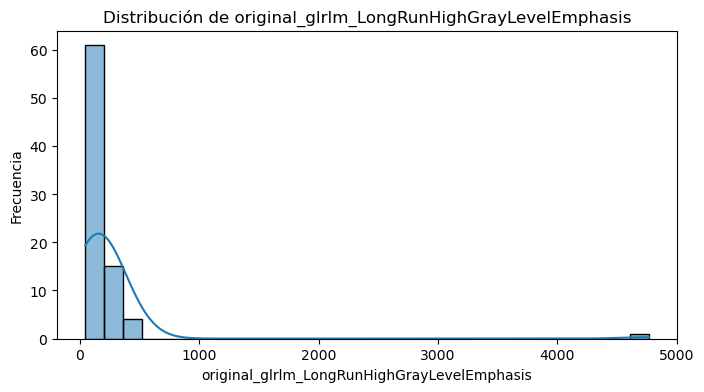

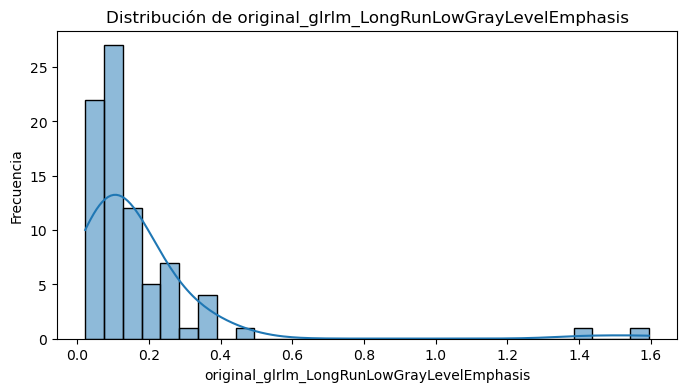

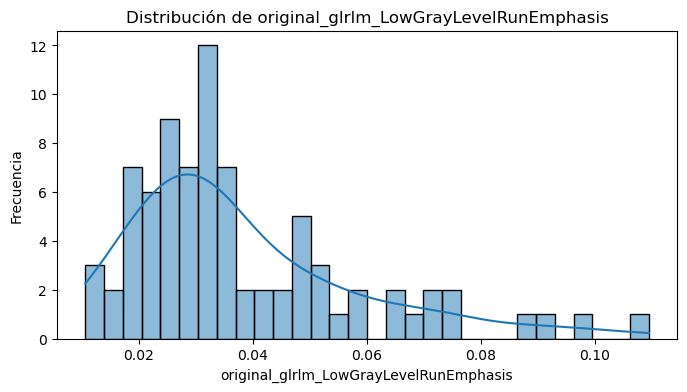

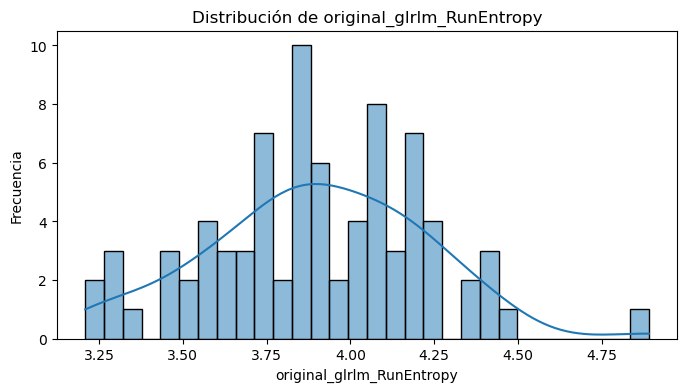

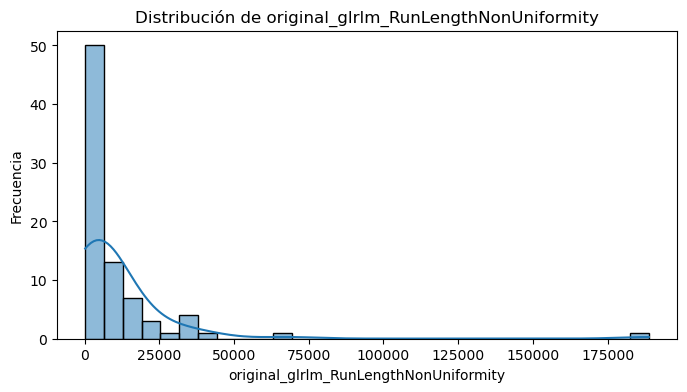

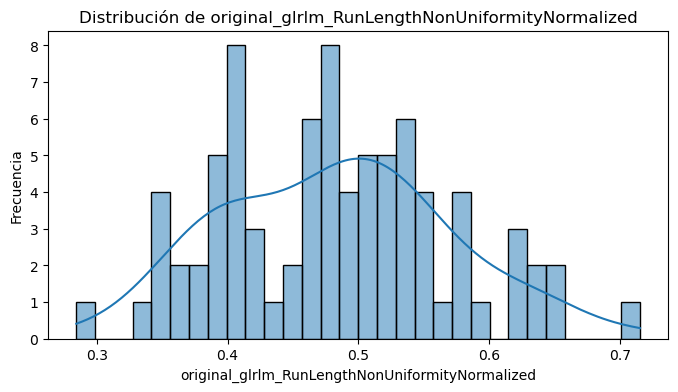

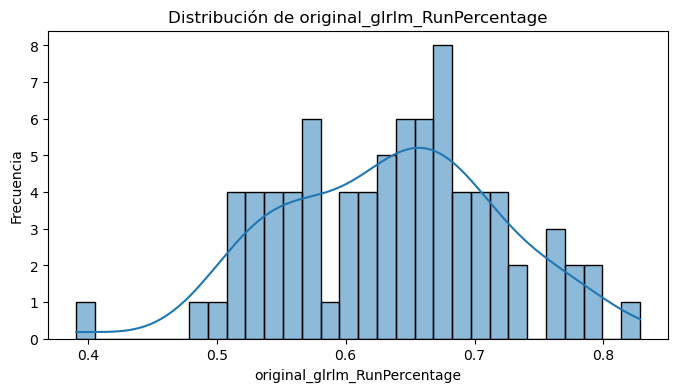

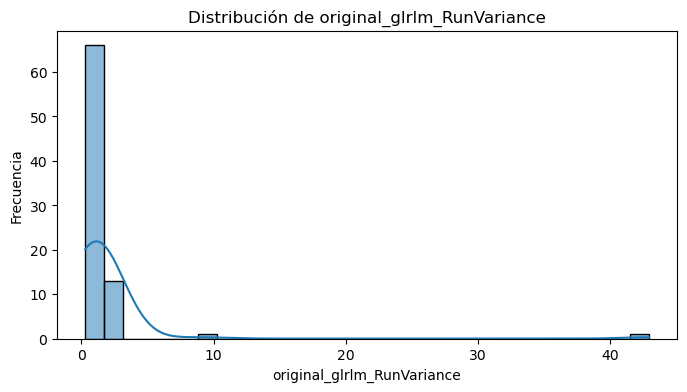

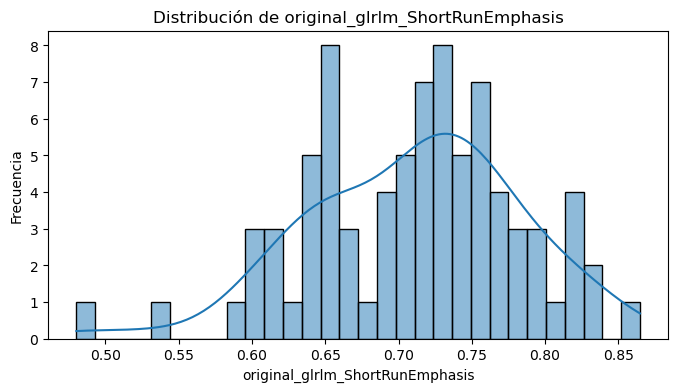

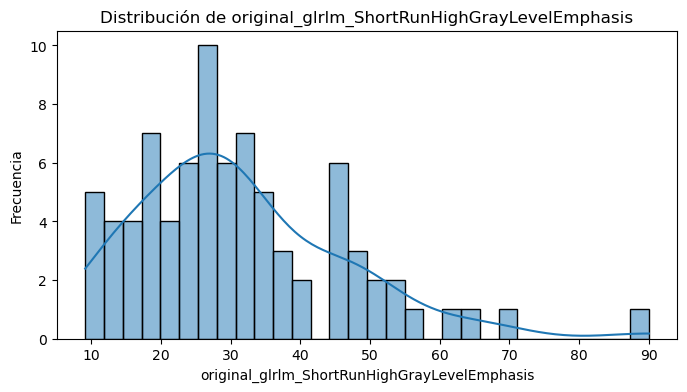

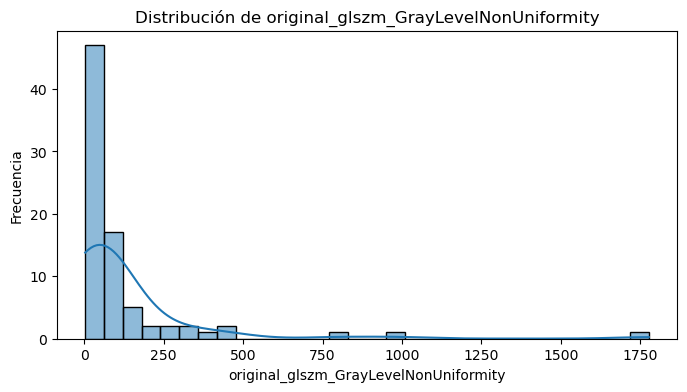

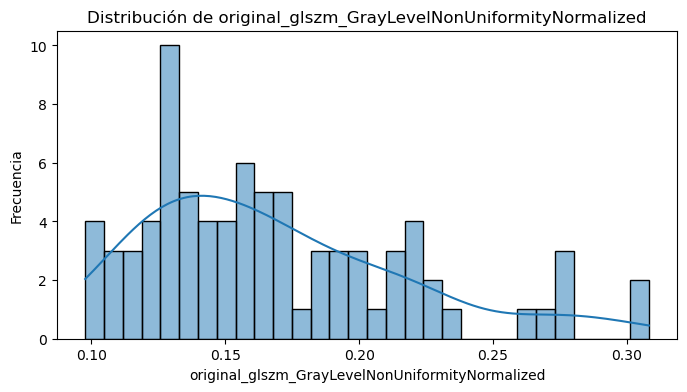

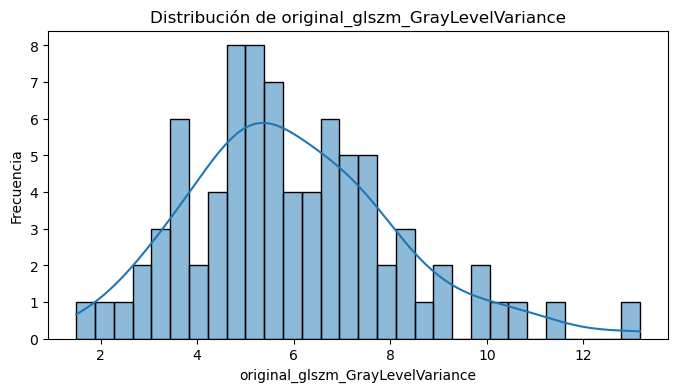

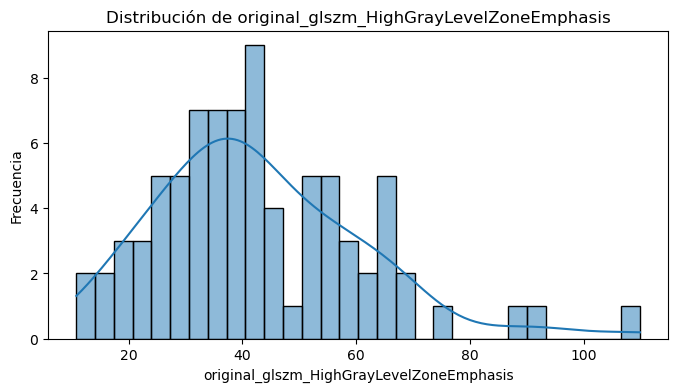

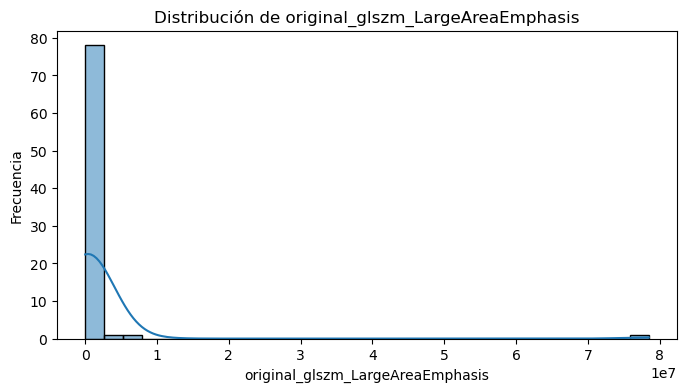

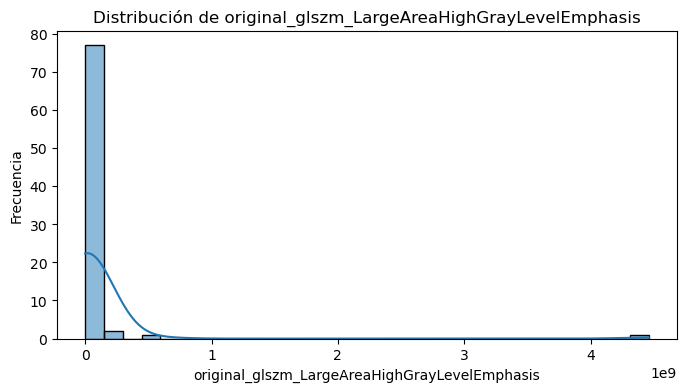

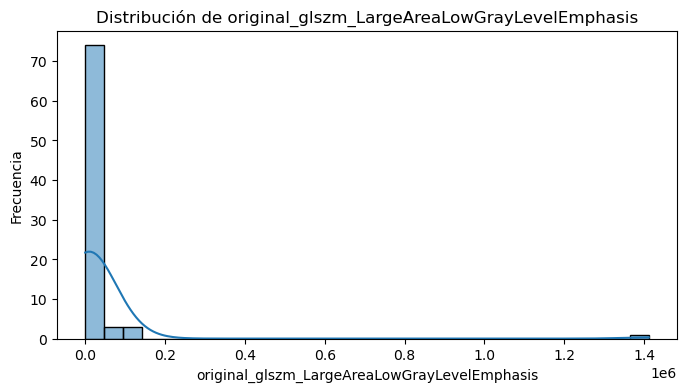

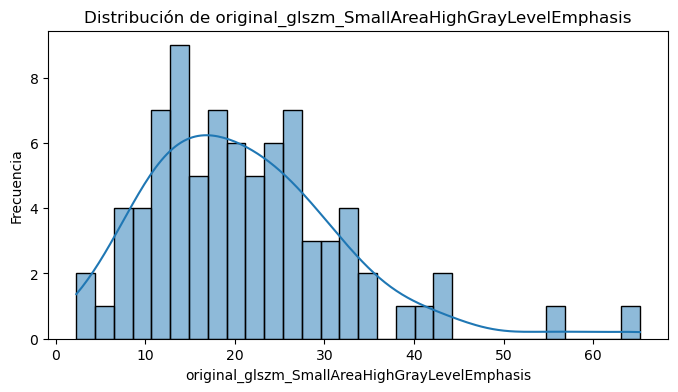

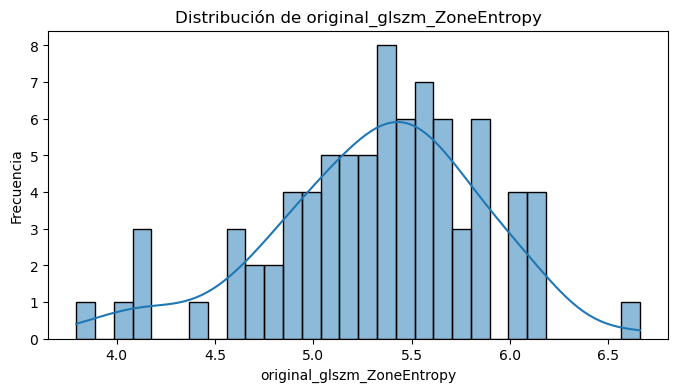

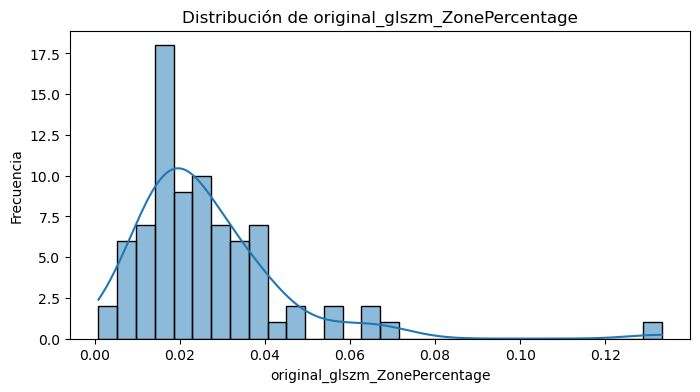

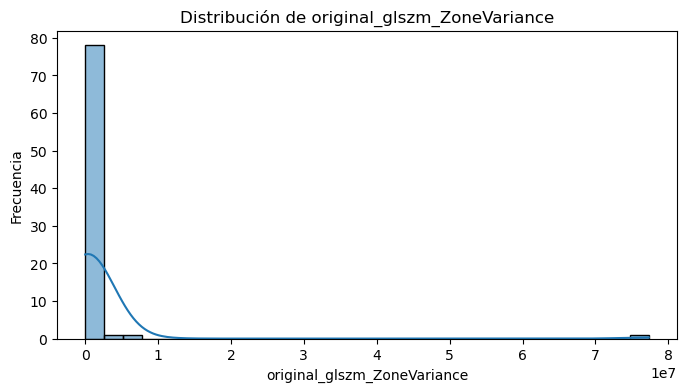

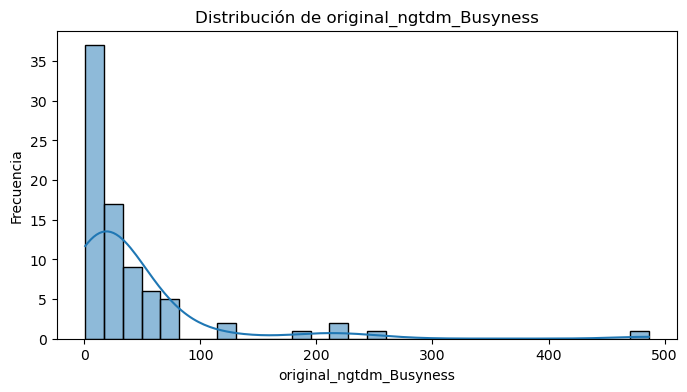

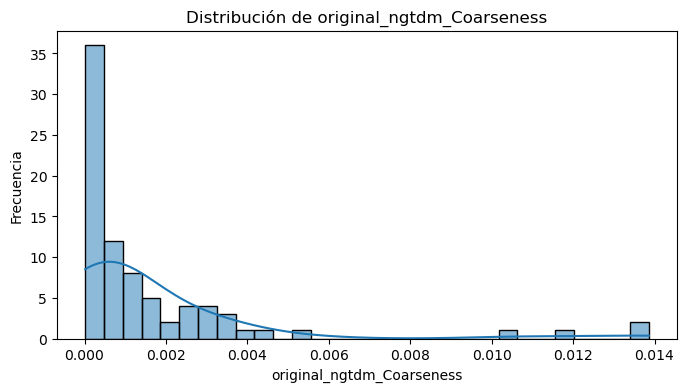

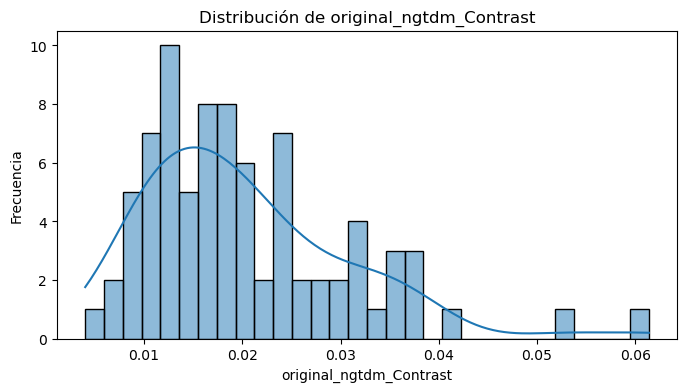

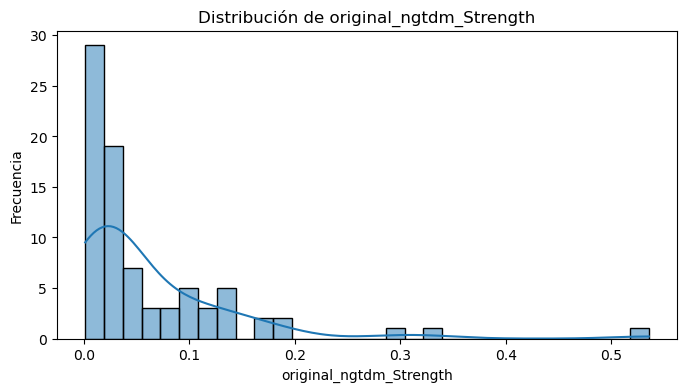

In [35]:
plot_variable_distribution(df_filt_interp)

In [36]:
print(len(df_filt_reseg.columns))

59


In [ ]:
# Pre-process for ML Algorithms

# Crea columna 'cancer' usando la columna 'subject'. True si subject acaba en 1, false si subject acaba en 0.
df_filt_reseg['cancer'] = df_filt_reseg['subject'].astype(str).str.endswith('1')

# Eliminar columna method.
df_filt_reseg.drop('method', axis=1, inplace=True)

X_reseg, y_reseg, removed_reseg = preprocess_features(df_filt_reseg, 'cancer')

Se eliminaron 18 variables con baja varianza.
Se eliminaron 22 variables altamente correlacionadas.
Se han eliminado 40 de 59 variables


In [41]:
print(len(removed_reseg))

40


In [39]:
print(len(X_reseg.columns))

18


# ML Algorithms

In [42]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, classification_report
)

In [43]:
models = {
        'DecisionTree': {
            'model': DecisionTreeClassifier(random_state=0),
            'params': {
                'max_depth': [5],
                'min_samples_split': [2]
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=0),
            'params': {
                'n_estimators': [100],
                'max_depth': [5]
            }
        },
        'GradientBoosting': {
            'model': GradientBoostingClassifier(random_state=0),
            'params': {
                'n_estimators': [100],
                'learning_rate': [0.1]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3],
                'weights': ['uniform']
            }
        }
    }

In [ ]:
# models = {
#         'DecisionTree': {
#             'model': DecisionTreeClassifier(random_state=0),
#             'params': {
#                 'max_depth': [None, 5, 10],
#                 'min_samples_split': [2, 5]
#             }
#         },
#         'RandomForest': {
#             'model': RandomForestClassifier(random_state=0),
#             'params': {
#                 'n_estimators': [100, 200],
#                 'max_depth': [None, 10]
#             }
#         },
#         'GradientBoosting': {
#             'model': GradientBoostingClassifier(random_state=0),
#             'params': {
#                 'n_estimators': [100, 200],
#                 'learning_rate': [0.01, 0.1]
#             }
#         },
#         'KNN': {
#             'model': KNeighborsClassifier(),
#             'params': {
#                 'n_neighbors': [3, 5, 7],
#                 'weights': ['uniform', 'distance']
#             }
#         }
#     }

In [44]:
def plot_confusion_matrix(cm, model_name, params, output_path='images'):
    """
    Dibuja y guarda la matriz de confusión.
    """
    os.makedirs(output_path, exist_ok=True)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}\n{params}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fname = f"cm_{model_name}_{abs(hash(frozenset(params.items())))}.png"
    plt.savefig(os.path.join(output_path, fname))
    plt.show()
    plt.close()


def plot_roc_curve(y_test, y_prob, model_name, params, output_path='images'):
    """
    Dibuja y guarda la curva ROC.
    """
    os.makedirs(output_path, exist_ok=True)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}\n{params}')
    plt.legend(loc='lower right')
    fname = f"roc_{model_name}_{abs(hash(frozenset(params.items())))}.png"
    plt.savefig(os.path.join(output_path, fname))
    plt.show()
    plt.close()

In [45]:
def evaluate_model(model, X_test, y_test, model_name, params):
    """
    Calcula métricas, muestra el reporte y dibuja CM y ROC.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"==> {model_name} {params}")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, model_name, params)
    plot_roc_curve(y_test, y_prob, model_name, params)

Training DecisionTree with {'max_depth': 5, 'min_samples_split': 2}
==> DecisionTree {'max_depth': 5, 'min_samples_split': 2}
  Accuracy : 0.7647
  Precision: 0.7273
  Recall   : 0.8889
  F1 Score : 0.8000
Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.62      0.71         8
        True       0.73      0.89      0.80         9

    accuracy                           0.76        17
   macro avg       0.78      0.76      0.76        17
weighted avg       0.78      0.76      0.76        17



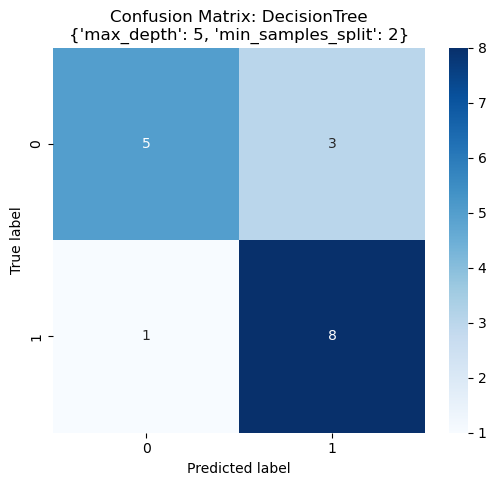

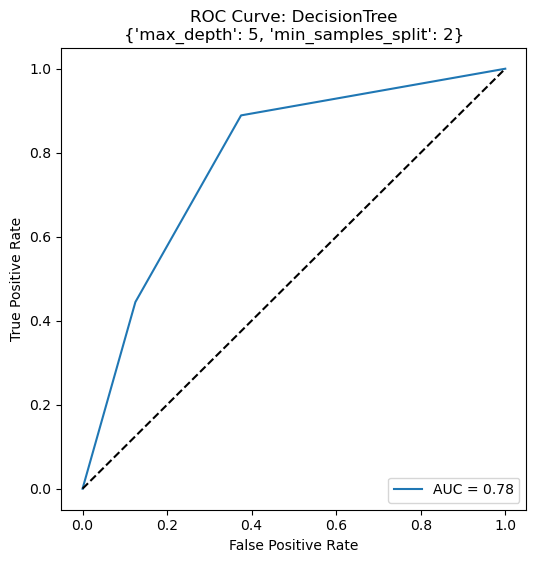

Training RandomForest with {'max_depth': 5, 'n_estimators': 100}
==> RandomForest {'max_depth': 5, 'n_estimators': 100}
  Accuracy : 0.6471
  Precision: 0.6364
  Recall   : 0.7778
  F1 Score : 0.7000
Classification Report:
              precision    recall  f1-score   support

       False       0.67      0.50      0.57         8
        True       0.64      0.78      0.70         9

    accuracy                           0.65        17
   macro avg       0.65      0.64      0.64        17
weighted avg       0.65      0.65      0.64        17



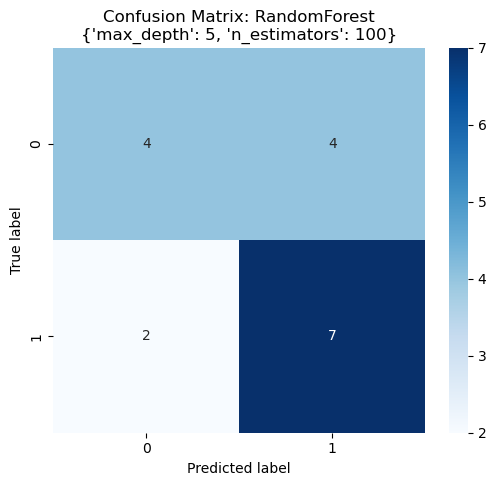

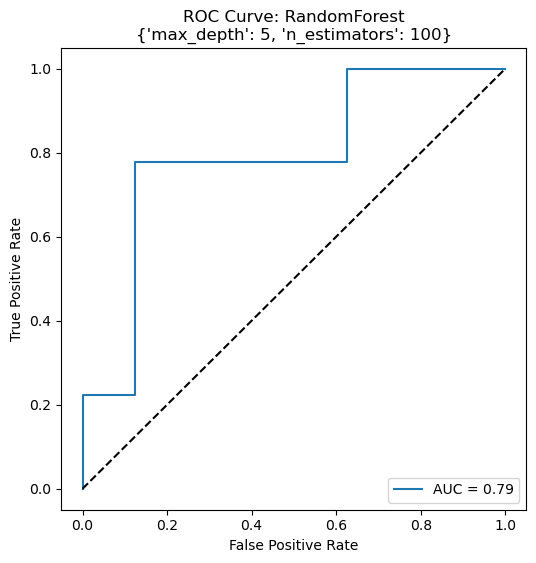

Training GradientBoosting with {'learning_rate': 0.1, 'n_estimators': 100}
==> GradientBoosting {'learning_rate': 0.1, 'n_estimators': 100}
  Accuracy : 0.8235
  Precision: 0.8000
  Recall   : 0.8889
  F1 Score : 0.8421
Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.75      0.80         8
        True       0.80      0.89      0.84         9

    accuracy                           0.82        17
   macro avg       0.83      0.82      0.82        17
weighted avg       0.83      0.82      0.82        17



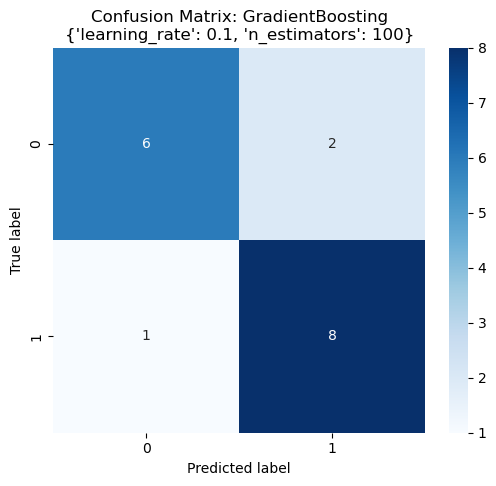

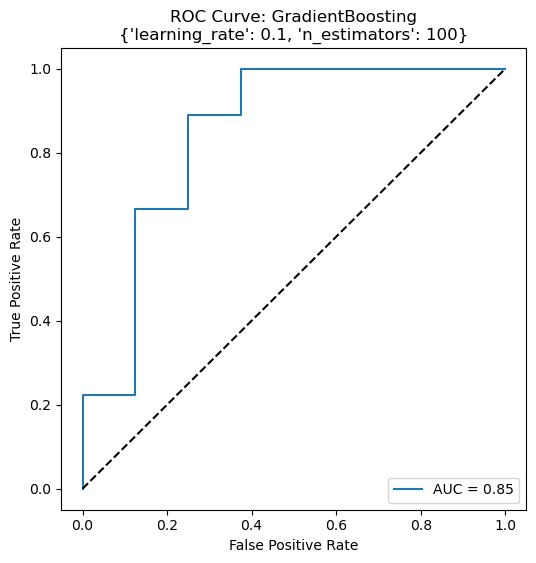

Training KNN with {'n_neighbors': 3, 'weights': 'uniform'}


AttributeError: 'Flags' object has no attribute 'c_contiguous'

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_reseg, y_reseg, test_size=0.2, random_state=42, stratify=y_reseg)

for name, cfg in models.items():
    base = cfg['model']
    for params in ParameterGrid(cfg['params']):
        print(f"Training {name} with {params}")
        model = base.set_params(**params)
        model.fit(X_train, y_train)
        evaluate_model(model, X_test, y_test, name, params)